In [1]:
from allensdk.brain_observatory.ecephys.dynamic_gating_ecephys_session import DynamicGatingEcephysSession

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os, glob

import matplotlib as mpl
import os
mpl.rcParams['pdf.fonttype'] = 42

In [192]:
#session = DynamicGatingEcephysSession.from_nwb_path(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\nwbs\1229429400\1229429400.nwb")
session = DynamicGatingEcephysSession.from_nwb_path(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\nwbs\1179670730\1179670730.nwb")

C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\hdmf\spec\namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\hdmf\utils.py:577: FutureWarning: VectorData.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)
C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\hdmf\utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


In [193]:
session.probes

name                 location  sampling_rate lfp_sampling_rate  has_lfp_data
id                                                                                 
946  probeA  See electrode locations   30000.125028              None         False
947  probeB  See electrode locations   29999.946210              None         False
948  probeC  See electrode locations   30000.217249              None         False
949  probeD  See electrode locations   30000.102053              None         False
950  probeE  See electrode locations   30000.068475              None         False
951  probeF  See electrode locations   30000.119084              None         False

In [194]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations.columns

Index(['active', 'color', 'contrast', 'duration', 'end_frame',
       'flashes_since_change', 'image_name', 'is_change', 'is_image_novel',
       'omitted', 'orientation', 'position_x', 'position_y', 'rewarded',
       'spatial_frequency', 'start_frame', 'start_time', 'stimulus_block',
       'stimulus_index', 'stimulus_name', 'end_time', 'temporal_frequency',
       'trials_id'],
      dtype='object')

In [195]:
eye_tracking = session.eye_tracking
running_speed = session.running_speed
licks = session.licks

In [196]:
eye_tracking_noblinks = eye_tracking[~eye_tracking['likely_blink']]

In [197]:
units = session.get_units()
quality_filter = ((units['isi_violations'] < 0.5) & 
                 (units['amplitude_cutoff']< 0.1) & 
                 (units['presence_ratio'] > 0.95) & 
                 (units['quality'] == 'good') &
                 #(units['amplitude'] > 500) &
                 #(units['max_drift'] < 20) &
                 ([True]*len(units)))

good_units = units[quality_filter]

In [198]:
len(good_units)

986

In [200]:
channels = session.get_channels()
good_units = good_units.merge(channels, left_on='peak_channel_id', right_index=True)
good_units = good_units.merge(session.probes, left_on='probe_id', right_index=True)
good_units = good_units[good_units['structure_acronym']!='No Area']
good_units.value_counts('structure_acronym')

structure_acronym
SSp         129
POL          71
SUB          62
ACAv5        60
VISp5        52
PL5          50
ACAd5        38
ACB          36
LSc          34
CP           27
ILA1         27
RSPv6a       24
RSPd5        22
TTd          22
MOs5         19
RPF          18
Eth          18
VISp6a       18
STR          15
VISp2/3      15
MB           14
LSr          14
VISrl4       14
RT           13
CA1          13
ILA2/3       13
VISp4        12
OP           12
PL2/3        12
SF           11
VISrl5       11
SGN          10
CA3           9
DG            8
ProS          8
TH            6
TRS           6
NPC           5
PoT           5
LGv           5
VPL           4
VISrl2/3      3
PPT           3
MRN           2
RSPd2/3       1
MOs2/3        1
LP            1
CA2           1
dtype: int64

In [3]:
structure_tree = pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating_insertions\ccf_structure_tree_2017.csv")

In [4]:
def get_parent(area, structure_tree):
    
    parent_id = structure_tree[structure_tree['acronym']==area]['parent_structure_id'].values[0]
    return structure_tree[structure_tree['id'] == parent_id]
    
def get_area(area, structure_tree):
    return structure_tree[structure_tree['acronym'] == area]
    
def list_parents(area, structure_tree):
    if area == 'root':
        return []
    
    area_info = get_area(area, structure_tree)
    if len(area_info['name'].values)>0:
        starting_entry = area_info['name'].values[0]
    else:
        starting_entry = ''
    
    parent_list = [starting_entry]
    parent_structure_id = 0.0
    
    try:
    
        while not np.isnan(parent_structure_id):
            parent = get_parent(area, structure_tree)
            parent_list.append(parent['name'].values[0])
            parent_structure_id = parent['parent_structure_id'].values[0]
            area = parent['acronym'].values[0]
    except:
        print(f'failed to get parents for {area}')
    
    return parent_list

def get_brain_division_for_area(area, structure_tree, 
                                divisions = ['Isocortex', 'Hippocampal formation', 
                                             'Thalamus', 'Midbrain', 'Hypothalamus',
                                             'Striatum', 'Olfactory areas'],
                               cached_dict = None):
    
    if cached_dict:
        if area in cached_dict.keys():
            return cached_dict[area]
        
    parents = list_parents(area, structure_tree)
    intersection = np.intersect1d(parents, divisions)
    if len(intersection)>0:
        return intersection[0]
    
    else:
        print(area)
        return 'not in list'
    
def get_area_color(area, structure_tree):
    
    area = get_area(area, structure_tree)
    if area.size>0:
        color = area['color_hex_triplet'].values[0]
    else:
        color = '808080'
    return '#' + color

In [5]:
unit_brain_divisions = good_units.apply(lambda row: get_brain_division_for_area(row['structure_acronym'], structure_tree), axis=1)
good_units['brain_division'] = unit_brain_divisions

NameError: name 'good_units' is not defined

In [202]:
good_units['brain_division'].value_counts()

Isocortex                521
Striatum                 137
Thalamus                 133
Hippocampal formation    101
Midbrain                  54
Olfactory areas           22
not in list                6
Name: brain_division, dtype: int64

In [203]:
brain_division_order = {
    'Isocortex': 1,
    'Hippocampal formation': 2,
    'Thalamus': 3,
    'Striatum': 4,
    'Midbrain': 5,
    'Olfactory areas': 6,
    'not in list': 7
}

good_units['brain_division_order'] = good_units.apply(lambda row: brain_division_order[row['brain_division']], axis=1)

In [5]:
def plot_raster(ax, units, spike_times, alignment_time, time_before = 1, time_after = 1):
        
    for iu, (uid, unit) in enumerate(units.iterrows()):
        
        area = unit['structure_acronym']
        color = get_area_color(area, structure_tree)
        
        spikes = spike_times[uid]
        spikes = spikes[(spikes>alignment_time-time_before)&(spikes<alignment_time+time_after)]
        
        spikes = spikes - alignment_time
        
        ax.eventplot(spikes, lineoffsets=iu, color=color)
                

In [6]:
def strip_subregions_layers(areastr):
    
    if not isinstance(areastr, str):
        return areastr
    
    areastr = areastr.split('-')[0]
    #remove layer stuff
    areaname = structure_tree[structure_tree['acronym']==areastr]['name'].values
    if len(areaname)==0:
        return areastr
    else:
        areaname = areaname[0]
        
    if 'layer' in areaname:
        layer = areaname.split('layer')[-1].split(' ')[-1]
        areastr = areastr.replace(layer, '')
        
    #hack for ACA and MOp which doesn't play nice
    if 'ACAd' in areastr:
        areastr = 'ACAd'
        
    if 'ACAv' in areastr:
        areastr = 'ACAv'

    if 'MOp' in areastr:
        areastr = 'MOp'
    
    if 'SC' in areastr:
        parents = list_parents(areastr, structure_tree)
        if 'Superior colliculus sensory related' in parents:
            areastr = 'SCs'
        elif 'Superior colliculus motor related' in parents:
            areastr = 'SCm'

    return areastr    
    

In [205]:
structure_acronym_no_layers = good_units.apply(lambda row: strip_subregions_layers(row['structure_acronym']), axis=1)
good_units['structure_acronym_no_layers'] = structure_acronym_no_layers

In [326]:
stimulus_presentations.head()

active  color  contrast  ...  no_reward_epoch  omitted_reward  is_sham_change
stimulus_presentations_id                           ...                                                 
0                            True    NaN       NaN  ...            False           False            True
1                            True    NaN       NaN  ...            False           False            True
2                            True    NaN       NaN  ...            False           False            True
3                            True    NaN       NaN  ...            False           False            True
4                            True    NaN       NaN  ...            False           False            True

[5 rows x 47 columns]

In [329]:
good_units.columns

Index(['PT_ratio', 'amplitude', 'amplitude_cutoff', 'cluster_id',
       'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations',
       'isolation_distance', 'l_ratio', 'local_index', 'max_drift',
       'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio',
       'quality', 'recovery_slope', 'repolarization_slope', 'silhouette_score',
       'snr', 'spread', 'velocity_above', 'velocity_below',
       'waveform_duration', 'anterior_posterior_ccf_coordinate',
       'dorsal_ventral_ccf_coordinate', 'filtering',
       'left_right_ccf_coordinate', 'probe_channel_number',
       'probe_horizontal_position', 'probe_id', 'probe_vertical_position',
       'structure_acronym', 'brain_division', 'brain_division_order',
       'structure_acronym_no_layers', 'name', 'location', 'sampling_rate',
       'lfp_sampling_rate', 'has_lfp_data'],
      dtype='object')

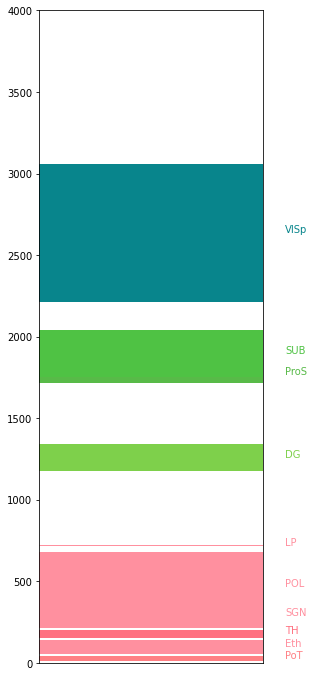

In [349]:
# make bar showing area boundaries for a particular probe
from matplotlib.patches import Rectangle

probe = 'probeC'

area_boundaries = probe_units.pivot_table(index='structure_acronym_no_layers', values = 'probe_vertical_position', aggfunc=(min, max))

fig, ax = plt.subplots()
fig.set_size_inches([4, 12])
for area, boundaries in area_boundaries.iterrows():
    area_color = get_area_color(area, structure_tree)
    start = boundaries['min']
    height = boundaries['max'] - boundaries['min']
    area_rectangle = Rectangle((0, boundaries['min']), 100, height, color=area_color)
    ax.add_artist(area_rectangle)
    ax.text(110, start+height/2, area, color=area_color)
    
ax.set_xlim([0, 100])
ax.set_ylim([0, 4000])

ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)
fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', '1179670730_probeC_areaboxes.pdf'))

In [342]:
start

2220

In [335]:
probe_units.pivot_table(index='structure_acronym_no_layers', values = 'probe_vertical_position', aggfunc=(min, max))

max   min
structure_acronym_no_layers            
DG                           1340  1180
Eth                           140    60
LP                            720   720
POL                           680   260
PoT                            40    20
ProS                         1820  1720
SGN                           360   220
SUB                          2040  1760
TH                            200   160
VISp                         3060  2220

In [206]:
last_nonrewarded_trial = np.where(session.trials['no_reward_epoch'])[0][-1]
session.trials.iloc[last_nonrewarded_trial]

start_time             2276.21077
stop_time              2284.46861
initial_image_name    im115_r-0.7
change_image_name     im115_r-0.7
is_change                    True
change_time            2279.98587
go                          False
catch                        True
lick_times                     []
response_time                 NaN
response_latency              inf
reward_time                   NaN
reward_volume                 0.0
hit                         False
false_alarm                 False
miss                        False
correct_reject               True
aborted                     False
auto_rewarded               False
change_frame             135030.0
trial_length              8.25784
no_reward_epoch              True
omitted_reward              False
is_sham_change               True
Name: 348, dtype: object

In [207]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations = stimulus_presentations.merge(session.trials, left_on='trials_id', right_index=True, suffixes=(None, '_trials'))

In [208]:
first_nonrewarded_trial = np.where(session.trials['no_reward_epoch'])[0][0]
session.trials.iloc[first_nonrewarded_trial]

nonrewarded_hits = stimulus_presentations[(stimulus_presentations['is_change'])&
                                               (stimulus_presentations['no_reward_epoch'])&
                                               (stimulus_presentations['hit'])]

In [209]:
first_reengaged_rewards = stimulus_presentations[(stimulus_presentations['is_change'])&
                                               (stimulus_presentations['auto_rewarded'])&
                                               (stimulus_presentations['trials_id']>10)]

first_reengaged_rewards

active  color  contrast  ...  no_reward_epoch  omitted_reward  is_sham_change
stimulus_presentations_id                           ...                                                 
100                          True    NaN       NaN  ...            False           False           False
3196                         True    NaN       NaN  ...            False           False           False
3235                         True    NaN       NaN  ...            False           False           False

[3 rows x 47 columns]

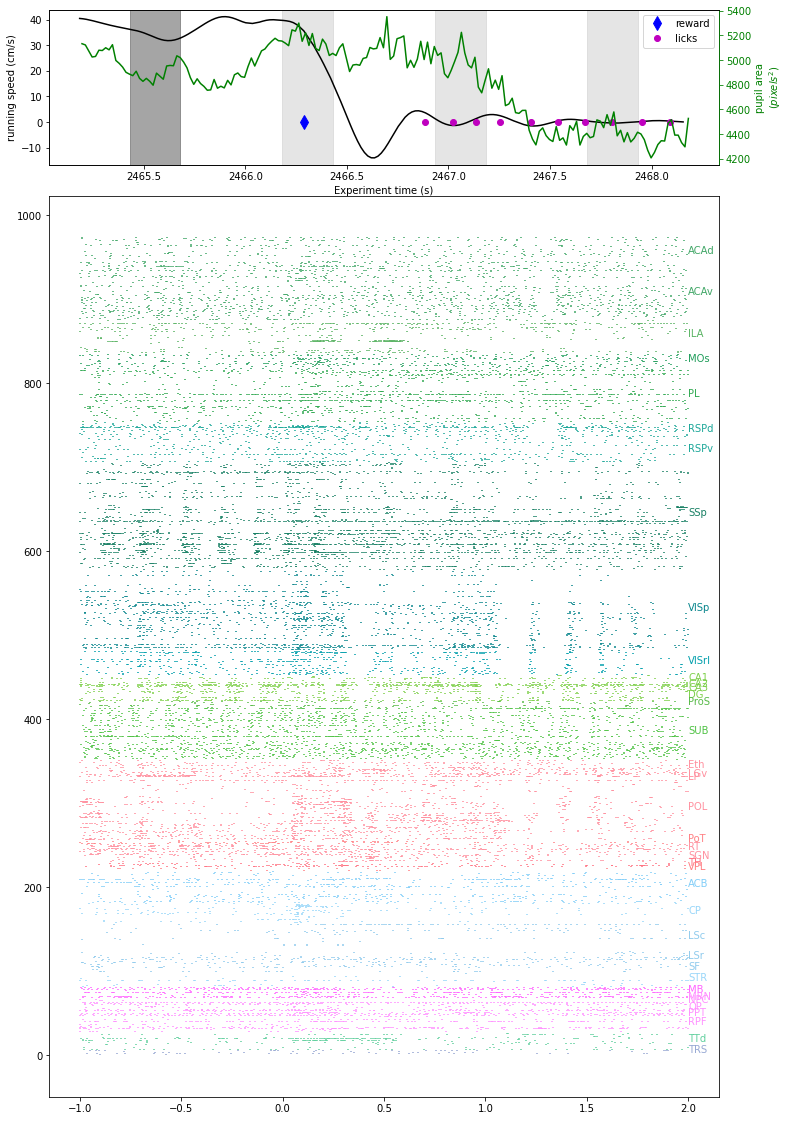

In [211]:
#align_time = first_nonrewarded_change.iloc[0]['start_time']
align_time = first_reengaged_rewards.iloc[2]['start_time']

#align_time = nonrewarded_hits.iloc[2]['start_time']
time_before = 1
time_after = 2
#Get running data aligned to this reward
trial_running = running_speed.query('timestamps >= {} and timestamps <= {} '.
                                    format(align_time-time_before, align_time+time_after))

#Get pupil data aligned to this reward
trial_pupil_area = eye_tracking_noblinks.query('timestamps >= {} and timestamps <= {} '.
                                    format(align_time-time_before, align_time+time_after))

#Get stimulus presentations around this reward
behavior_presentations = stimulus_presentations[stimulus_presentations['active']]
behavior_presentations = behavior_presentations[(behavior_presentations['omitted']==False)]
trial_stimuli = behavior_presentations.query('end_time >= {} and start_time <= {}'.
                                             format(align_time-time_before, align_time+time_after))

#Get licking aligned to this reward
trial_licking = licks.query('timestamps >= {} and timestamps <= {} '.
                                    format(align_time-time_before, align_time+time_after))

reward_time = session.rewards.query('timestamps >= {} and timestamps <= {} '.
                                    format(align_time-time_before, align_time+time_after))['timestamps'].values[0]



fig = plt.figure(figsize=(12, 20))
spec = fig.add_gridspec(6, 1)

ax_spikes = fig.add_subplot(spec[1:])
axr = fig.add_subplot(spec[0])

plot_raster(ax_spikes, good_units.sort_values(by=['brain_division_order', 'structure_acronym', 'dorsal_ventral_ccf_coordinate'], ascending=False), 
            session.spike_times, align_time, time_before=time_before, time_after= time_after)

#Plot running, pupil area and licks
axr.plot(trial_running['timestamps'], trial_running['speed'], 'k')
axp = axr.twinx()
axp.plot(trial_pupil_area['timestamps'], trial_pupil_area['pupil_area'], 'g')
rew_handle, = axr.plot(reward_time, 0, 'db', markersize=10)
lick_handle, = axr.plot(trial_licking['timestamps'], np.zeros(len(trial_licking['timestamps'])), 'mo')
axr.legend([rew_handle, lick_handle], ['reward', 'licks'])

axr.set_ylabel('running speed (cm/s)')
axp.set_ylabel('pupil area\n$(pixels^2)$')
axr.set_xlabel('Experiment time (s)')

axp.yaxis.label.set_color('g')
axp.spines['right'].set_color('g')
axp.tick_params(axis='y', colors='g')

#Plot the image flashes as grey bars. 
colors = ['0.3', '0.8']
stimulus_colors = {stim: c for stim,c in zip(trial_stimuli['image_name'].unique(), colors)}
for idx, stimulus in trial_stimuli.iterrows():
    axr.axvspan(stimulus['start_time'], stimulus['end_time'], color=stimulus_colors[stimulus['image_name']], alpha=0.5)
    
    
area_labels = good_units.sort_values(by=['brain_division_order', 'structure_acronym', 'dorsal_ventral_ccf_coordinate'], ascending=False)['structure_acronym_no_layers'].values
for label in np.unique(area_labels):
    indices = np.where(area_labels==label)[0]
    label_positions[label] = np.median(indices)
    ax_spikes.text(time_after, np.median(indices), label, color=get_area_color(label, structure_tree))

## Panel showing waveform stability over time

In [227]:
waveform = session.mean_waveforms[332929]
waveform.max() - waveform.min()

272.73148500000025

In [ ]:
good_units['max_drift']

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_23584\4108148813.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


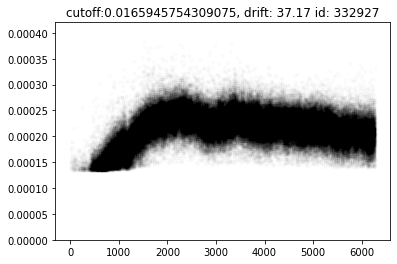

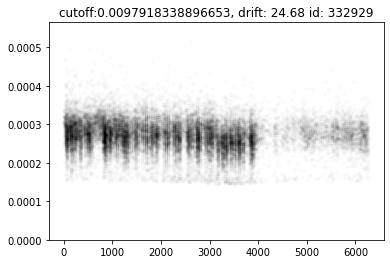

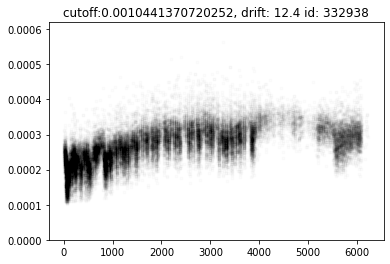

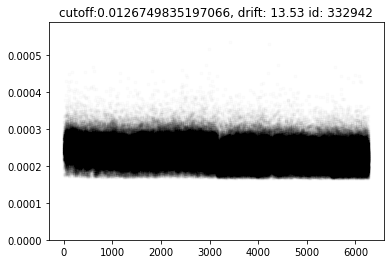

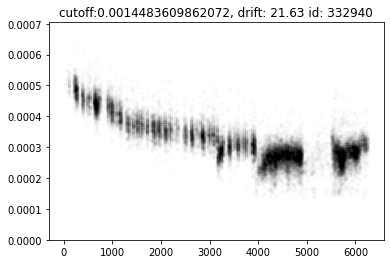

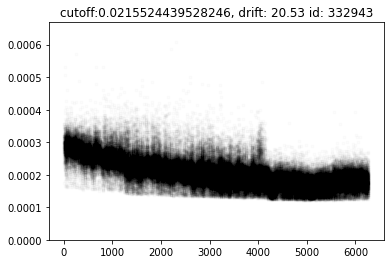

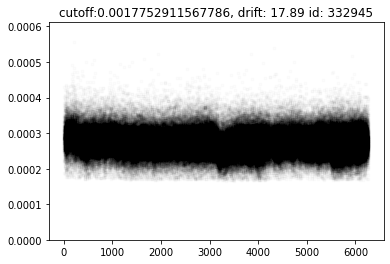

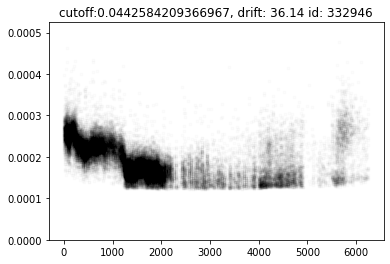

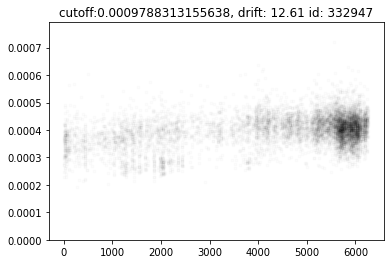

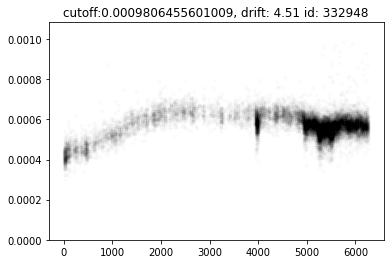

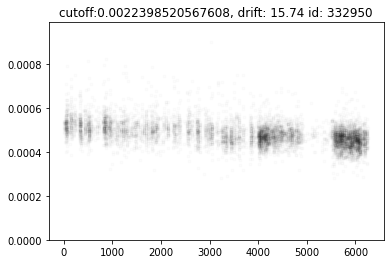

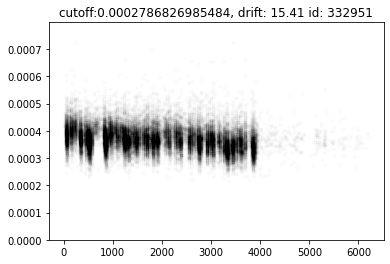

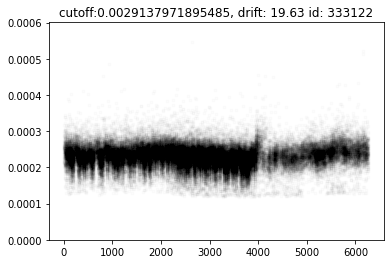

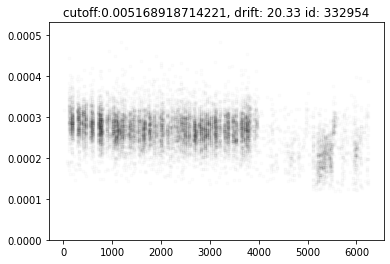

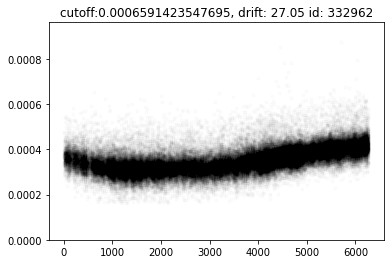

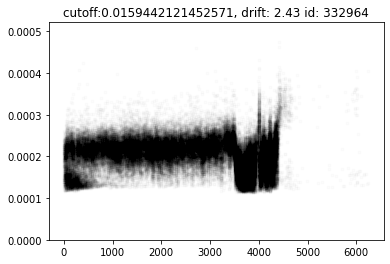

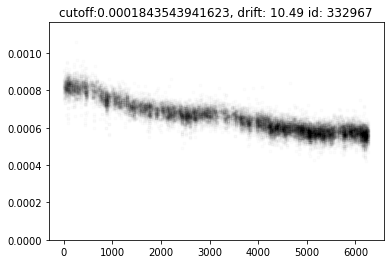

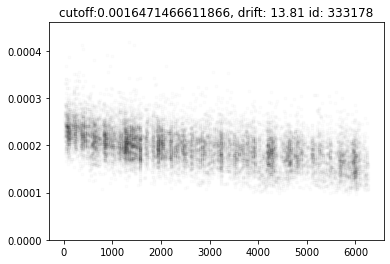

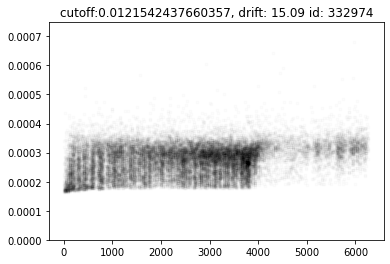

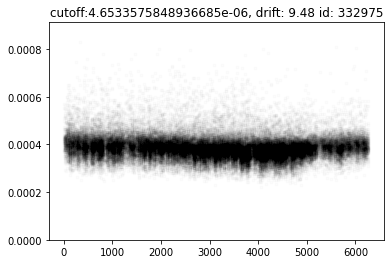

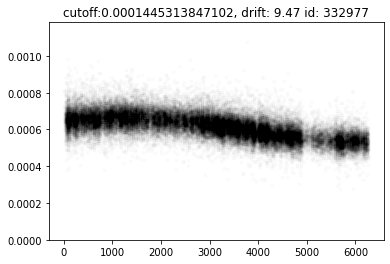

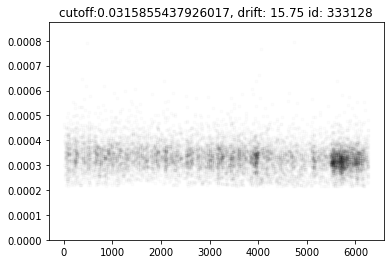

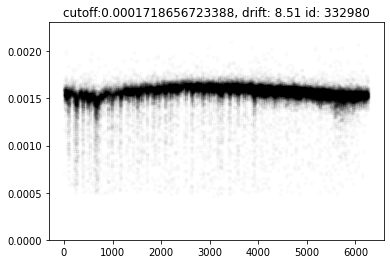

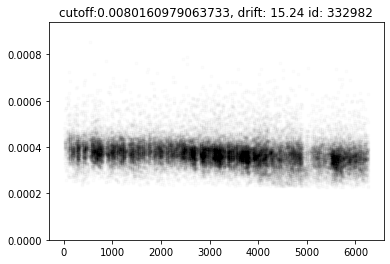

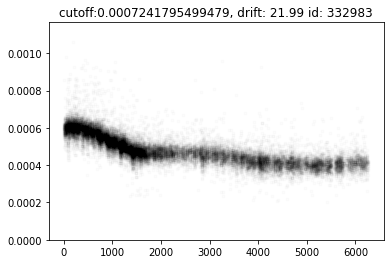

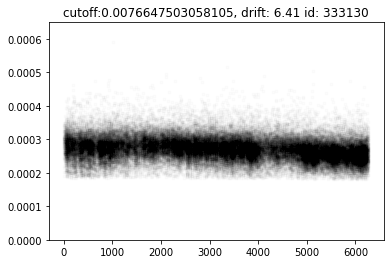

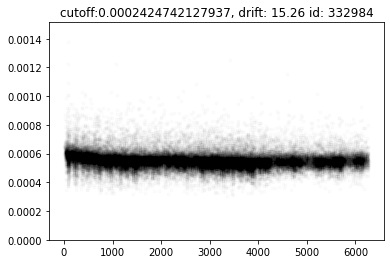

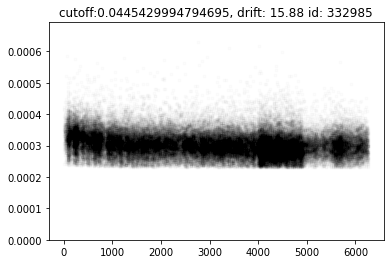

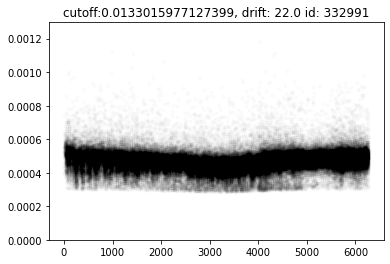

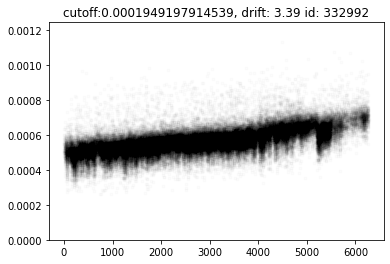

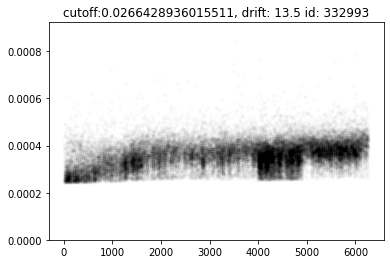

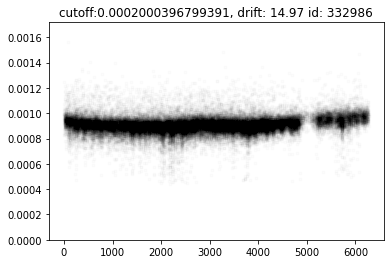

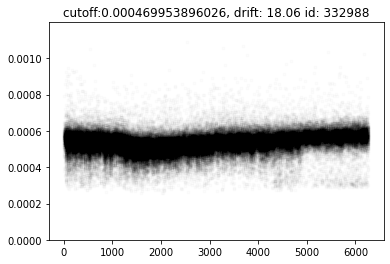

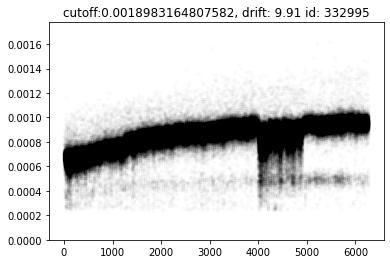

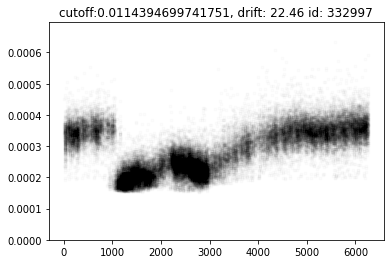

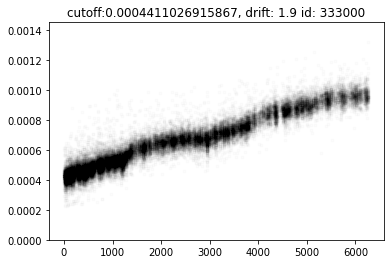

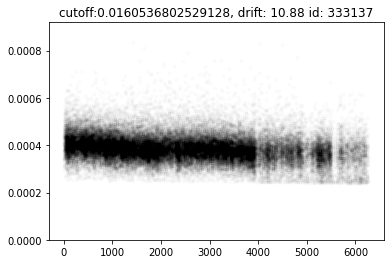

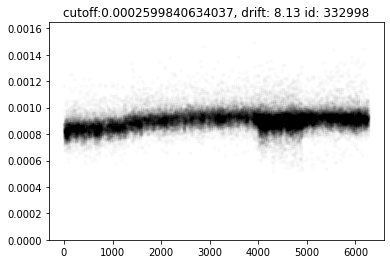

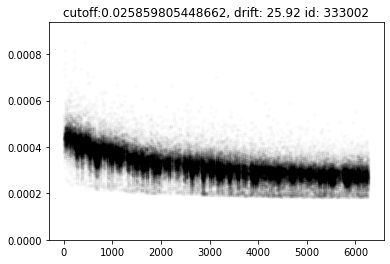

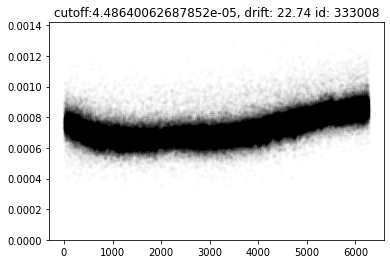

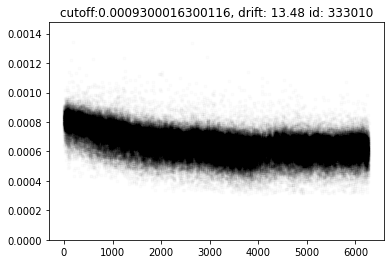

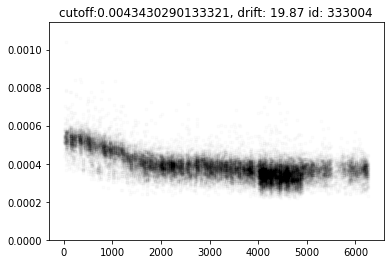

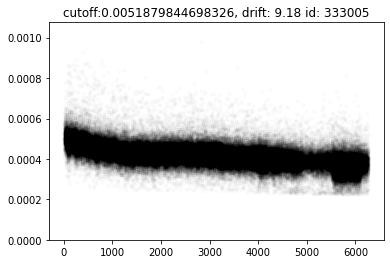

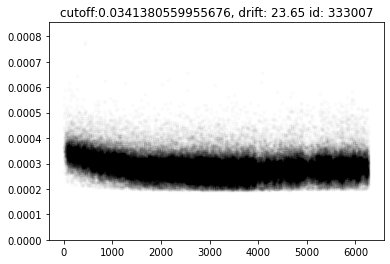

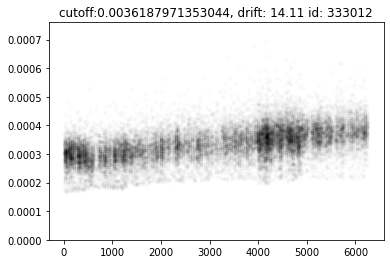

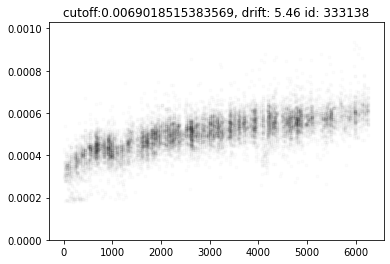

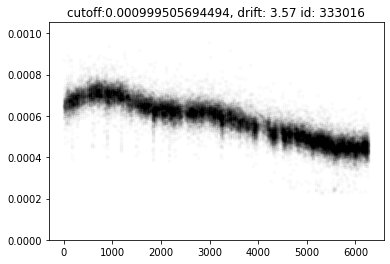

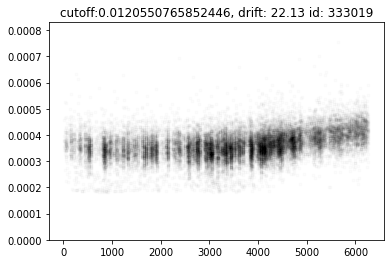

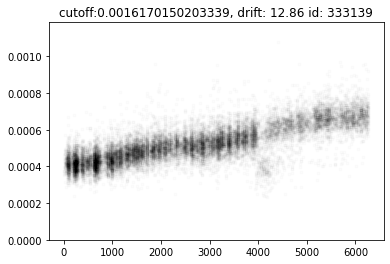

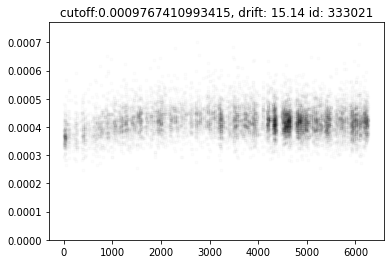

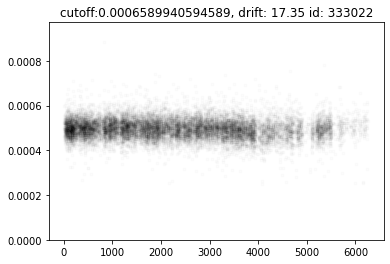

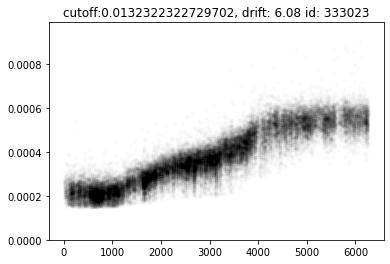

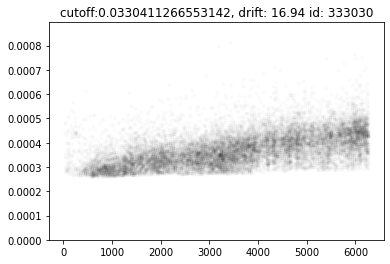

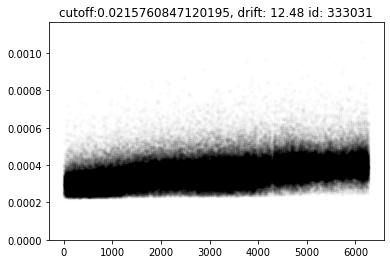

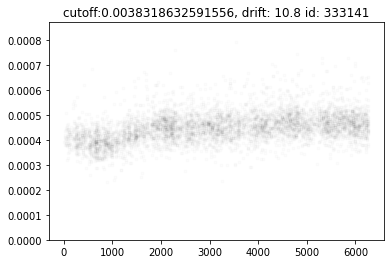

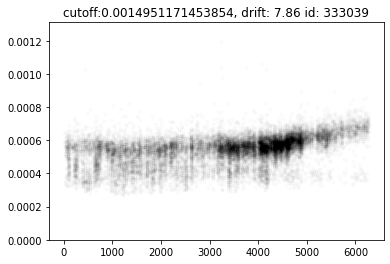

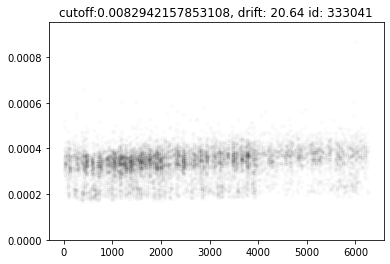

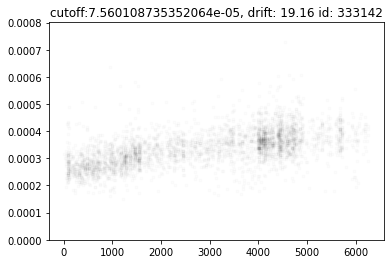

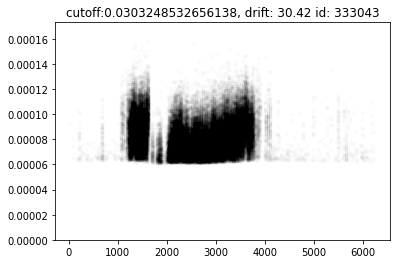

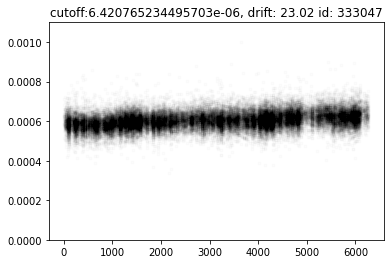

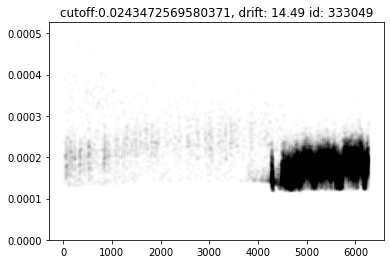

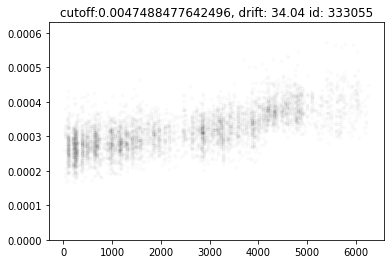

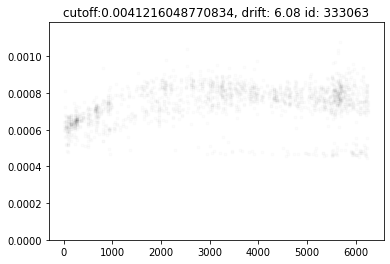

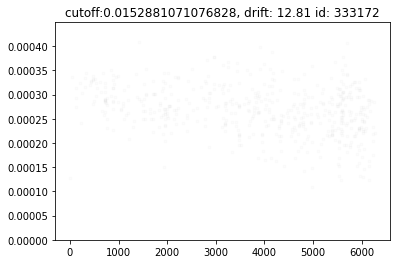

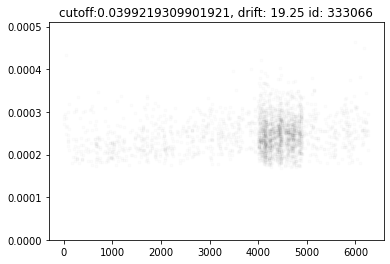

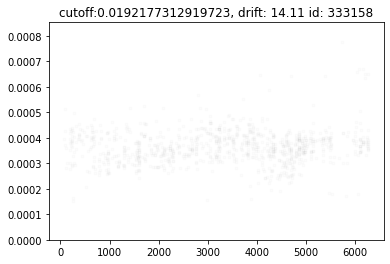

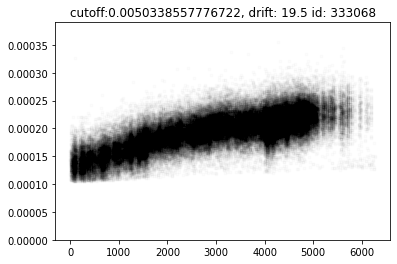

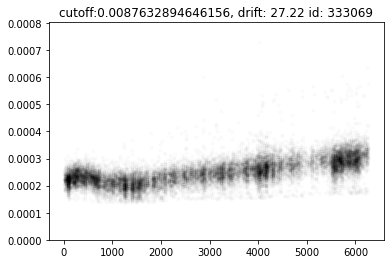

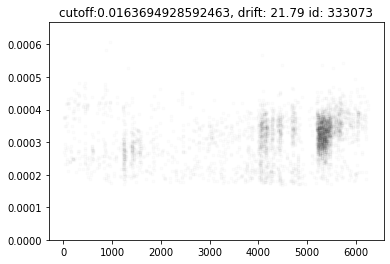

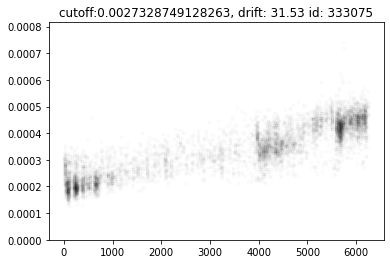

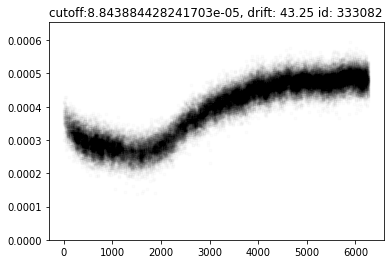

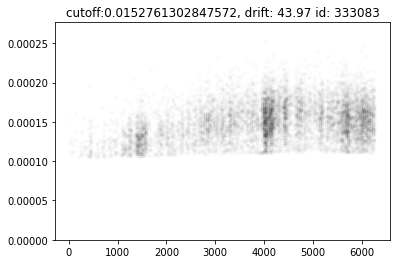

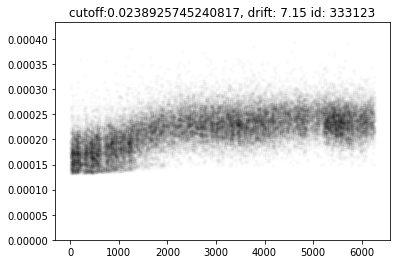

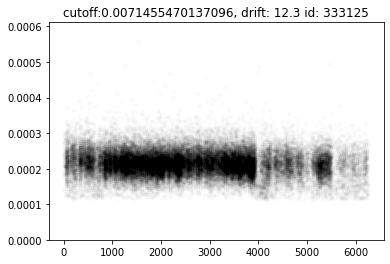

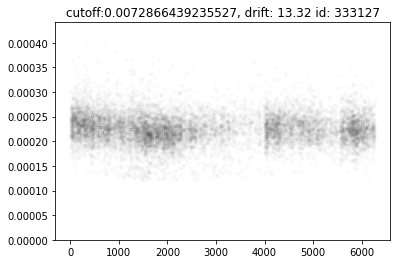

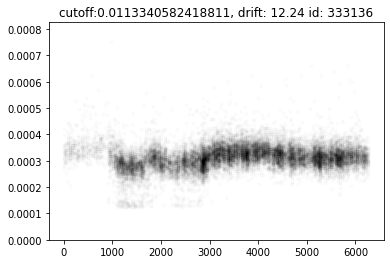

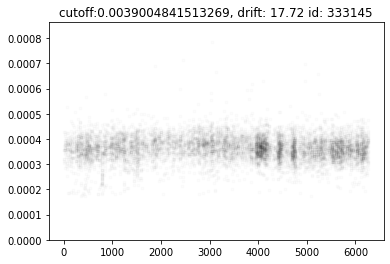

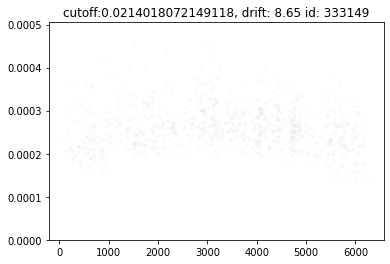

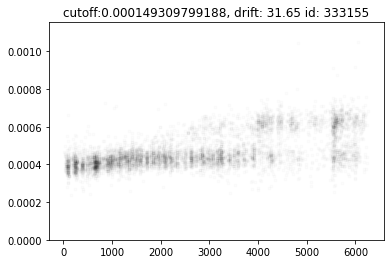

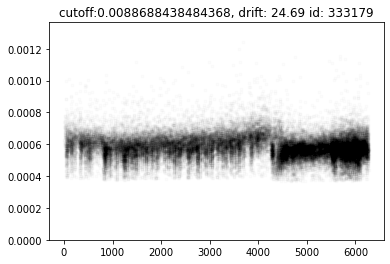

In [350]:
visp = good_units[(good_units['structure_acronym_no_layers']=='VISp')&(good_units['amplitude_cutoff']<0.05)]
for ir, row in visp.iterrows():
    
    amplitudes = session.spike_amplitudes[ir]
    times = session.spike_times[ir]
    fig, ax = plt.subplots()
    ax.plot(times, amplitudes, 'k.', alpha=0.01)
    ax.set_ylim([0, amplitudes.max()*1.1])
    
    ax.set_title(f'cutoff:{row["amplitude_cutoff"]}, drift: {row["max_drift"]} id: {ir}')

In [236]:
visp = good_units[(good_units['structure_acronym_no_layers']=='VISp')&(good_units['amplitude_cutoff']<0.05)]
visp['name']

id
332927    probeC
332929    probeC
332938    probeC
332942    probeC
332940    probeC
           ...  
333136    probeC
333145    probeC
333149    probeC
333155    probeC
333179    probeC
Name: name, Length: 80, dtype: object

In [234]:
good_units = good_units.merge(session.probes, left_on='probe_id', right_index=True)

In [237]:
raw_data = np.memmap(r"\\allen\programs\mindscope\workgroups\np-exp\1179670730_612090_20220524\1179670730_612090_20220524_probeC_sorted\continuous\Neuropix-PXI-100.0\continuous.dat",
                    dtype='int16', mode='r')
raw_data = np.reshape(raw_data, [int(raw_data.size/384), -1])


In [241]:
raw_data.shape

(187923429, 384)

In [583]:
#Look at waveform stability over time

unitid = 332984
#unitid = 333022
unit_times = session.spike_times[unitid]
unit_peak_chan = good_units.loc[unitid]['probe_channel_number']

unit_data = raw_data[:, unit_peak_chan - 20: unit_peak_chan + 20]

offset = 4.82447193064198
samplerate = 30000.21724868578

maxtime = stimulus_presentations['end_time'].max()
epoch_number = 5
epoch_starts = np.arange(0, maxtime, int(np.round(maxtime/epoch_number)))
epoch_ends = np.append(epoch_starts[1:], maxtime)

epoch_waveforms = []
for es, ee in zip(epoch_starts, epoch_ends):
    times = unit_times[(unit_times>es)&(unit_times<=ee)]
    waveforms = []
    for spike in times[:100]:
        sample = int((spike-offset)*samplerate)

        waveform = unit_data[sample-50:sample+50]
        waveforms.append(waveform)

    mean_waveform = np.mean(waveforms,axis=0)*0.195
    epoch_waveforms.append(mean_waveform)

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_23584\2821270742.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[ie].pcolor(np.arange(-50, 50)/30., np.arange(-20, 20, 2),
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_23584\2821270742.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[ie].pcolor(np.arange(-50, 50)/30., np.arange(-20, 20, 2),
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_23584\2821270742.py:8: MatplotlibDeprecationWarning: shading='fl

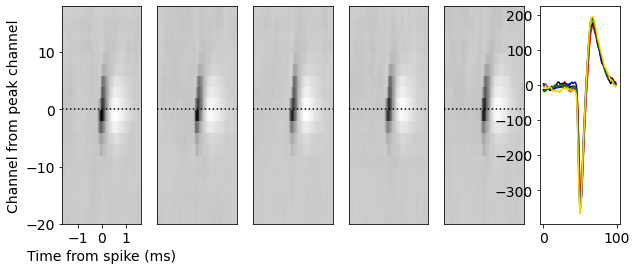

In [588]:
grand_min = np.min(epoch_waveforms)
grand_max = np.max(epoch_waveforms)
fig, ax = plt.subplots(1, epoch_number+1)
fig.set_size_inches(10, 4)
colors = ['k', 'r', 'b', 'g', 'gold']
for ie, epoch in enumerate(epoch_waveforms):
    #ax[ie].imshow(epoch.T)
    ax[ie].pcolor(np.arange(-50, 50)/30., np.arange(-20, 20, 2), 
                  epoch[:, ::2].T, cmap='Greys_r', vmin = grand_min, vmax=grand_max)
    ax[ie].axhline(0, ls='dotted', c='k')
    #ax[ie].set_title(np.max(epoch) - np.min(epoch))
    if ie==0:
        ax[ie].set_xlabel('Time from spike (ms)')
        ax[ie].set_ylabel('Channel from peak channel')
    else:
        ax[ie].xaxis.set_visible(False)
        ax[ie].yaxis.set_visible(False)

    ax[5].plot(epoch[:, 20], colors[ie])
    
fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 'waveform_stability_example_332984_1179670730.pdf'))

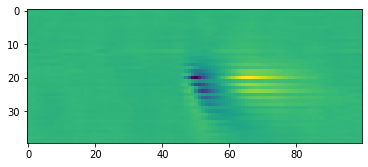

In [285]:
plt.plot()

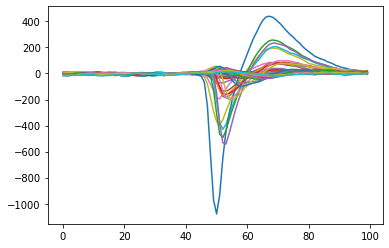

In [324]:
fig, ax = plt.subplots()
ax.plot(mean_waveform)

In [325]:
max(mean_waveform) - min(mean_waveform)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [264]:
good_units.loc[unitid]['amplitude']

551.8572150000006

In [190]:
fig.savefig(os.path.join(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures", 'trial_raster_1229429400_timezoom.pdf'))

In [50]:
area_labels = good_units.sort_values(by=['brain_division_order', 'structure_acronym', 'dorsal_ventral_ccf_coordinate'], ascending=False)['structure_acronym'].values

In [57]:
label_positions = {a:0 for a in np.unique(area_labels)}
for label in np.unique(area_labels):
    indices = np.where(area_labels==label)[0]
    label_positions[label] = np.median(indices)

label_positions

{'ACAd6a': 619.0,
 'AV': 189.0,
 'CA1': 238.0,
 'ILA6a': 605.0,
 'ILA6b': 592.0,
 'LSr': 156.0,
 'MB': 100.0,
 'MOs2/3': 588.0,
 'MOs5': 571.0,
 'MOs6a': 542.0,
 'MRN': 84.0,
 'NB': 80.0,
 'OLF': 22.5,
 'PAG': 71.5,
 'PL6a': 508.5,
 'PL6b': 487.0,
 'POST': 207.0,
 'RSPagl6a': 485.0,
 'RSPd2/3': 483.0,
 'RSPd5': 474.0,
 'RSPd6a': 462.0,
 'RSPd6b': 457.5,
 'RSPv2/3': 455.5,
 'RSPv5': 436.5,
 'RSPv6a': 412.5,
 'SCdg': 64.5,
 'SCdw': 62.0,
 'SCig': 58.0,
 'SCiw': 51.5,
 'SCop': 46.0,
 'SCzo': 43.0,
 'SSp': 374.5,
 'STR': 124.0,
 'TTd': 1.0,
 'VISl2/3': 341.0,
 'VISl4': 336.5,
 'VISl5': 326.0,
 'VISl6a': 316.0,
 'VISli6a': 304.0,
 'VISli6b': 290.5,
 'VISp2/3': 286.0,
 'VISp4': 284.0,
 'VISp5': 276.0,
 'VISp6a': 265.0}

## Panel comparing quality metrics for DG and VBN

In [5]:
PASSING_EPHYS_SESSION_IDS = [1182427414, 1182628226, 1182871514, 1183071525, 1177900858,
       1178173272, 1178460518, 1178693650, 1174553025, 1174790219,
       1175067685, 1175253205, 1176580734, 1176791184, 1176989662,
       1189336645, 1189820015, 1190094328, 1190290940, 1179670730,
       1179911454, 1180107381, 1180266229, 1181096406, 1181324124,
       1181731440, 1187475832, 1187668018, 1188138256, 1190892228,
       1191131853, 1191375883, 1191631184, 1197514969, 1197725774,
       1197967151, 1198130743, 1194411467, 1194850630, 1195036753,
       1198796984, 1198995158, 1199249150, 1199448636, 1208053773,
       1208664393, 1209073822, 1200260055, 1200471383, 1200659846,
       1202438738, 1202644967, 1203574877, 1204636084, 1210343162,
       1210608527, 1210863396, 1214217748, 1214409109, 1214566710,
       1214740195, 1218577463, 1218795542, 1219127153, 1219401111,
       1226010097, 1226251663, 1226528572, 1227622013, 1227855488,
       1230732154, 1230962048, 1231219674, 1229429400, 1229654875,
       1229887685, 1230064747, 1234028213, 1234203203, 1234410451,
       1232430325, 1232725697, 1232954220, 1233182785, 1243523806,
       1243799530, 1244070169]

In [6]:
#%pip install openpyxl
#dynamic_gating_sessions = pd.read_excel(r"C:\Users\svc_ccg\ccb_onedrive\OneDrive - Allen Institute\DynamicGatingProduction_final.xlsx")
dynamic_gating_sessions = pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\nwbs\dynamic_gating_ecephys_sessions_table_07242023.csv")
dynamic_gating_probes = pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\nwbs\probes_table_09142023.csv")


In [7]:
dynamic_gating_sessions

ecephys_session_id  behavior_session_id date_of_acquisition  \
0           1182427414         1.182459e+09            6/6/2022   
1           1182628226         1.182662e+09            6/7/2022   
2           1182871514         1.182900e+09            6/8/2022   
3           1183071525         1.183102e+09            6/9/2022   
4           1177900858         1.177961e+09           5/17/2022   
..                 ...                  ...                 ...   
94          1243523806         1.243590e+09           1/30/2023   
95          1243799530         1.243848e+09           1/31/2023   
96          1244070169         1.244098e+09            2/1/2023   
97          1173189336                  NaN                 NaN   
98          1173741216                  NaN                 NaN   

   equipment_name session_type  mouse_id  \
0            NP.1      EPHYS_1  607660.0   
1            NP.1      EPHYS_2  607660.0   
2            NP.1      EPHYS_3  607660.0   
3            NP.1      EPHYS_4  607660.0   
4            NP.1      EPHYS_1  608671.0   
..            ...          ...       ...   
94           NP.1      EPHYS_1  642504.0   
95           NP.1      EPHYS_2  642504.0   
96           NP.1      EPHYS_3  642504.0   
97            NaN          NaN       NaN   
98            NaN          NaN       NaN   

                                         genotype  sex       project_code  \
0   Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    F  DynamicGating_DEV   
1   Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    F  DynamicGating_DEV   
2   Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    F  DynamicGating_DEV   
3   Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    F  DynamicGating_DEV   
4   Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    M  DynamicGating_DEV   
..                                            ...  ...                ...   
94  Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    F      DynamicGating   
95  Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    F      DynamicGating   
96  Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    F      DynamicGating   
97                                            NaN  NaN                NaN   
98                                            NaN  NaN                NaN   

    age_in_days                                    probes_inserted  \
0         225.0  ['probeA', 'probeB', 'probeC', 'probeE', 'prob...   
1         225.0  ['probeA', 'probeB', 'probeC', 'probeD', 'prob...   
2         225.0  ['probeA', 'probeB', 'probeC', 'probeD', 'prob...   
3         225.0  ['probeA', 'probeB', 'probeC', 'probeD', 'prob...   
4         222.0           ['probeC', 'probeD', 'probeE', 'probeF']   
..          ...                                                ...   
94        202.0  ['probeA', 'probeB', 'probeC', 'probeE', 'prob...   
95        202.0  ['probeA', 'probeB', 'probeC', 'probeE', 'prob...   
96        202.0  ['probeA', 'probeB', 'probeC', 'probeE', 'prob...   
97          NaN                                                NaN   
98          NaN                                                NaN   

    unit_count  channel_count  \
0       2267.0         1920.0   
1       2452.0         2304.0   
2       2605.0         2304.0   
3       2375.0         2304.0   
4       1871.0         1536.0   
..         ...            ...   
94      1419.0         1920.0   
95      1607.0         1920.0   
96      1682.0         1920.0   
97         NaN            NaN   
98         NaN            NaN   

                                   structure_acronyms  session_number  \
0   ['SUB', 'SCig', 'out of brain', 'Track not ann...             1.0   
1   ['VISl', 'CP', 'VISpm', 'SCig', 'out of brain'...             2.0   
2   ['CP', 'VISal', 'out of brain', 'PPT', 'ProS',...             3.0   
3   ['VPM', 'VISl', 'CP', 'out of brain', 'POL', '...             4.0   
4   ['VISal', 'out of brain', 'Track not annotated...             1.0   
..                                                ...             ...

In [8]:
dg_sessions_passing = dynamic_gating_sessions[dynamic_gating_sessions['ecephys_session_id'].isin(PASSING_EPHYS_SESSION_IDS)]
mouse_info = dg_sessions_passing.groupby('mouse_id').head(1)
print(mouse_info.value_counts('genotype'))
print(mouse_info.value_counts('sex'))


genotype
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    14
wt/wt                                             6
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     4
Ai32(RCL-ChR2(H134R)_EYFP)/wt                     1
dtype: int64
sex
M    18
F     7
dtype: int64


In [9]:
len(PASSING_EPHYS_SESSION_IDS)

87

In [412]:
dg_metrics = pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\units_with_rf_metrics.csv")

In [413]:
dg_metrics = dg_metrics[dg_metrics['session_id'].isin(PASSING_EPHYS_SESSION_IDS)]
dg_probes = pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\probes_table_with_inserted.csv")
dg_metrics_with_corrected_insertions = dg_metrics.merge(dg_probes, left_on='probe_id', right_on='id', suffixes=['', '_probes'])
dg_metrics_with_corrected_insertions = dg_metrics_with_corrected_insertions[dg_metrics_with_corrected_insertions['inserted']]

In [414]:
number_of_insertions = dg_metrics_with_corrected_insertions['probe_id'].unique().size
print(f'number_of_insertions: {number_of_insertions}')
number_of_experiments = dg_metrics_with_corrected_insertions['session_id'].unique().size
print(f'number_of_experiments: {number_of_experiments}')

number_of_mice = dynamic_gating_sessions[dynamic_gating_sessions['ecephys_session_id'].isin(PASSING_EPHYS_SESSION_IDS)]['mouse_id'].unique().size
print(f'number_of_mice: {number_of_mice}')


number_of_insertions: 467
number_of_experiments: 87
number_of_mice: 25


In [425]:
dg_metrics_with_corrected_insertions = dg_metrics_with_corrected_insertions.merge(dynamic_gating_sessions, left_on='session_id', right_on='ecephys_session_id')

In [437]:
probe_insertions_per_mouse = dg_metrics_with_corrected_insertions.pivot_table(index='mouse_id', values='probe_id', aggfunc=lambda x: len(np.unique(x)))

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 3.,
        3., 4., 2., 0., 0., 3., 6.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

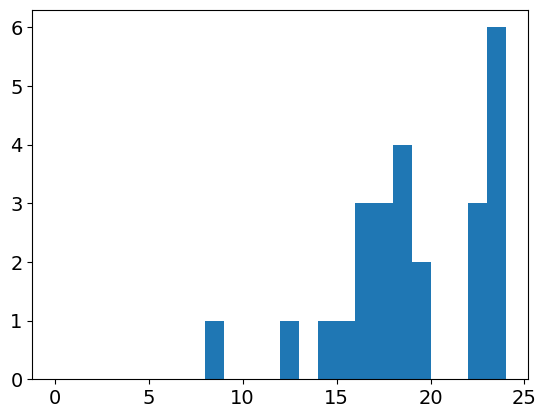

In [440]:
fig, ax = plt.subplots()
ax.hist(probe_insertions_per_mouse, bins=np.arange(25))

In [439]:
probe_insertions_per_mouse.max()

probe_id    24
dtype: int64

In [435]:
m['probe_id']

51757     562
51758     562
51759     562
51760     562
51761     562
         ... 
123909    561
123910    561
123911    561
123912    561
123913    561
Name: probe_id, Length: 4597, dtype: int64

In [12]:
number_of_insertions = dg_metrics['probe_id'].unique().size
print(f'number_of_insertions: {number_of_insertions}')
number_of_experiments = dg_metrics['session_id'].unique().size
print(f'number_of_experiments: {number_of_experiments}')

number_of_mice = dynamic_gating_sessions[dynamic_gating_sessions['ecephys_session_id'].isin(PASSING_EPHYS_SESSION_IDS)]['mouse_id'].unique().size
print(f'number_of_mice: {number_of_mice}')


number_of_insertions: 513
number_of_experiments: 87
number_of_mice: 25


In [13]:
def convert_date(date_str):
    dateparts = date_str.split('/')
    newdateparts = []
    for d in dateparts:
        if len(d)==1:
            d = '0'+ d
        newdateparts.append(d)
    return newdateparts

In [14]:
good_probe_ids = dg_metrics['probe_id'].unique()
good_probes = dynamic_gating_probes[dynamic_gating_probes['id'].isin(good_probe_ids)]

mouseids = []
dates = []
probe_names = []
session_ids = []
for ir, probeinfo in good_probes.iterrows():
    probe_name = probeinfo['name']
    probe_name = probe_name.replace('p', 'P')
    probe_name = probe_name.replace('e', 'e_')
    
    probe_names.append(probe_name)

    session = probeinfo['session']
    session_info = dynamic_gating_sessions[dynamic_gating_sessions['ecephys_session_id']==session]

    mouseid = session_info['mouse_id'].values[0]
    mouseids.append(str(int(mouseid)))
    date = session_info['date_of_acquisition'].values[0]
    date_parts = convert_date(date)
    dates.append(date_parts[2]+date_parts[0]+date_parts[1])

    session_ids.append(session)

globs = []
for m, d, pn in zip(mouseids, dates, probe_names):
    globs.append(m + '_' + d + '_' + pn)

globs

['640890_20221213_Probe_A',
 '640890_20221213_Probe_B',
 '640890_20221213_Probe_C',
 '640890_20221213_Probe_D',
 '640890_20221213_Probe_E',
 '640890_20221213_Probe_F',
 '640887_20221220_Probe_A',
 '640887_20221220_Probe_B',
 '640887_20221220_Probe_C',
 '640887_20221220_Probe_D',
 '640887_20221220_Probe_E',
 '640887_20221220_Probe_F',
 '632295_20221017_Probe_A',
 '632295_20221017_Probe_B',
 '632295_20221017_Probe_C',
 '632295_20221017_Probe_D',
 '632295_20221017_Probe_E',
 '632295_20221017_Probe_F',
 '608671_20220520_Probe_A',
 '608671_20220520_Probe_B',
 '608671_20220520_Probe_C',
 '608671_20220520_Probe_D',
 '608671_20220520_Probe_E',
 '608671_20220520_Probe_F',
 '611160_20220513_Probe_A',
 '611160_20220513_Probe_B',
 '611160_20220513_Probe_C',
 '611160_20220513_Probe_D',
 '611160_20220513_Probe_E',
 '611160_20220513_Probe_F',
 '614547_20220601_Probe_A',
 '614547_20220601_Probe_B',
 '614547_20220601_Probe_C',
 '614547_20220601_Probe_D',
 '614547_20220601_Probe_E',
 '614547_20220601_Pr

In [139]:
import shutil

drift_raster_dir = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\drift_rasters"
new_drift_raster_dir = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\production_drift_rasters"

no_drift_map_glob = []
no_drift_map_sessions = []
for globstr, sid in zip(globs, session_ids):
    globfile = glob.glob(os.path.join(drift_raster_dir, globstr+'*'))
    if len(globfile)==0:
        no_drift_map_glob.append(globstr)
        no_drift_map_sessions.append(sid)
        continue

    for gf in globfile:
        shutil.copyfile(gf, os.path.join(new_drift_raster_dir, str(sid) + '_' + os.path.basename(gf)))

print(f'num missing insertions: {len(no_drift_map_glob)}')

num missing insertions: 21


In [136]:
session_drift_missing = []
for session in np.unique(no_drift_map_sessions):

    session_dir = glob.glob(os.path.join(r'\\allen\programs\mindscope\workgroups\np-exp', str(session)+'*'))[0]
    drift_map_files = glob.glob(os.path.join(session_dir, 'qc', 'probe_yield', 'unit_distribution', '*depth_map.png'))

    if len(drift_map_files)==0:
        session_drift_missing.append(session_dir)
        continue

    for df in drift_map_files:
        base = os.path.basename(df)
        shutil.copyfile(df, os.path.join(drift_raster_dir, base))

In [15]:
insertion_success_rate = number_of_insertions/number_of_experiments

In [16]:
dg_metrics_inarea = dg_metrics[~dg_metrics['structure_acronym'].isin(['No Area', 'out of brain', 'Track not annotated'])]

In [17]:
num_insertions_per_session = dg_metrics_inarea.pivot_table(index='session_id', values='probe_id', aggfunc=lambda x: np.unique(x).size)

In [18]:
six_probe_experiments = num_insertions_per_session[num_insertions_per_session==6]
six_probe_experiments = six_probe_experiments.dropna().index.values

dg_metrics_inarea_six_probes = dg_metrics_inarea[dg_metrics_inarea['session_id'].isin(six_probe_experiments)]

In [19]:
df_to_use = dg_metrics_inarea_six_probes

number_of_areas_per_experiment = df_to_use.pivot_table(index='session_id', values='structure_acronym', 
                            aggfunc=lambda x: len(np.unique(x)))

print(f'areas recorded per experiment: {number_of_areas_per_experiment.mean()} +/- {number_of_areas_per_experiment.std()}')

quality_filter = ((df_to_use['isi_violations'] < 0.5) & 
                 (df_to_use['amplitude_cutoff']< 0.1) & 
                 (df_to_use['presence_ratio'] > 0.95) & 
                 (df_to_use['quality'] == 'good'))
quality_filter = (df_to_use['quality']=='good')

number_of_units_per_experiment = df_to_use[quality_filter].pivot_table(index='session_id', values='structure_acronym', 
                            aggfunc='count')
print(f'units recorded per experiment: {number_of_units_per_experiment.mean()} +/- {number_of_units_per_experiment.std()}')


areas recorded per experiment: structure_acronym    28.113636
dtype: float64 +/- structure_acronym    5.122753
dtype: float64
units recorded per experiment: structure_acronym    1820.977273
dtype: float64 +/- structure_acronym    341.870266
dtype: float64


In [118]:
#vbn_metrics = pd.read_csv(r"\\allen\programs\mindscope\workgroups\np-behavior\vbn_data_release\supplemental_tables\master_unit_table.csv")
vbn_metrics = pd.read_csv(r"\\allen\programs\mindscope\workgroups\np-behavior\vbn_data_release\vbn_s3_cache\visual-behavior-neuropixels-0.5.0\project_metadata\units.csv")
vbn_sessions = pd.read_csv(r"\\allen\programs\mindscope\workgroups\np-behavior\vbn_data_release\vbn_s3_cache\visual-behavior-neuropixels-0.5.0\project_metadata\ecephys_sessions.csv")

vbn_metrics = vbn_metrics.merge(vbn_sessions, on='ecephys_session_id')

In [403]:
dg_probes

Unnamed: 0   id    name                 location  sampling_rate  \
0             0  541  probeA  See electrode locations   30000.112321   
1             1  543  probeB  See electrode locations   29999.933151   
2             2  539  probeC  See electrode locations   30000.232314   
3             3  540  probeD  See electrode locations   30000.093798   
4             4  538  probeE  See electrode locations   30000.061832   
..          ...  ...     ...                      ...            ...   
579         579  546  probeC  See electrode locations   30000.232824   
580         580  547  probeD  See electrode locations   30000.093436   
581         581  548  probeE  See electrode locations   30000.061308   
582         582  549  probeF  See electrode locations   30000.107441   
583         583  361  probeA  See electrode locations   30000.100847   

     lfp_sampling_rate  has_lfp_data     session  inserted  
0                  NaN         False  1232725697      True  
1                  NaN         False  1232725697      True  
2                  NaN         False  1232725697      True  
3                  NaN         False  1232725697      True  
4                  NaN         False  1232725697     False  
..                 ...           ...         ...       ...  
579                NaN         False  1232954220      True  
580                NaN         False  1232954220      True  
581                NaN         False  1232954220      True  
582                NaN         False  1232954220      True  
583                NaN         False  1214409109      True  

[584 rows x 9 columns]

In [253]:
dg_good = dg_metrics[dg_metrics['quality']=='good']
dg_good = dg_good.merge(dynamic_gating_sessions, left_on='session', right_on='ecephys_session_id')
dg_probes = pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\probes_table_with_inserted.csv")
dg_good = dg_good.merge(dg_probes, left_on='probe_id', right_on='id', suffixes=['', '_probes'])
dg_good = dg_good[dg_good['inserted']]

#Didn't filter for abnormal activity in original draft, trying it out here
vbn_good = vbn_metrics[(vbn_metrics['quality']=='good')]#&(vbn_metrics['abnormal_histology'].isnull())&(vbn_metrics['abnormal_activity'].isnull())]

In [254]:
def filter_by_quality(table):
    quality_filter = ((table['isi_violations'] < 0.5) & 
                 (table['amplitude_cutoff']< 0.1) & 
                 (table['presence_ratio'] > 0.95) & 
                 (table['quality'] == 'good'))
    return table[quality_filter]

percentage_dg_passing_quality_metrics = len(filter_by_quality(dg_good))/len(dg_good)
percentage_vbn_passing_quality_metrics = len(filter_by_quality(vbn_good))/len(vbn_good)

print(f'dg pass % {100*percentage_dg_passing_quality_metrics} \n vbn pass % {100*percentage_vbn_passing_quality_metrics}')

dg pass % 41.143588174764304 
 vbn pass % 40.69006816005981


In [225]:
from scipy.stats import mannwhitneyu
import scipy.stats
mannwhitneyu(dg_good['max_drift'].values, vbn_good['max_drift'].values, nan_policy='omit')

MannwhitneyuResult(statistic=19690761471.0, pvalue=3.061923651927496e-290)

In [360]:
print(f'num dg units: {len(dg_good)}')
print(f'num vbn units: {len(vbn_good)}')


num dg units: 143828
num vbn units: 262177


In [227]:
def bootstrap_median_CI(values, num_iterations=1000, CI_span=95):
    sample_medians = []
    for iteration in range(num_iterations):
        sample_values = np.random.choice(values, len(values))
        sample_medians.append(np.median(sample_values))
    
    one_side = (100-CI_span)/2
    CI = [np.percentile(sample_medians, p) for p in [one_side, 100-one_side]]

    return CI

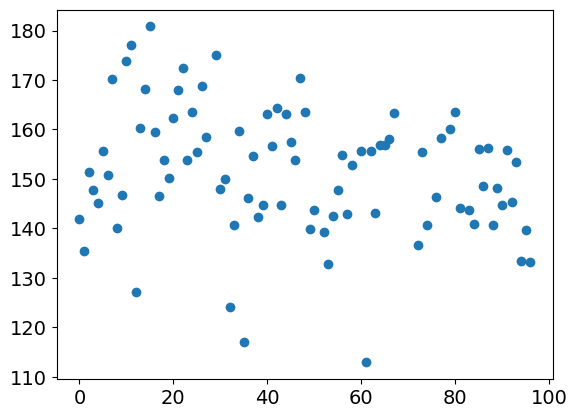

In [358]:
#identify DG sessions with scale issue
dg_sessionwise_amplitudes = dg_good.pivot_table(index='session', values='amplitude')
plt.plot(dg_sessions_passing.index.values, dg_sessionwise_amplitudes['amplitude'], 'o')
dg_needscaling_sessions = dg_sessionwise_amplitudes[dg_sessionwise_amplitudes>250].dropna()
#dg_good[dg_good['session'].isin(dg_needscaling_sessions), 'amplitude'] /=2

In [257]:
scaled_amplitudes = dg_good[dg_good['session'].isin(dg_needscaling_sessions.index.values)]['amplitude']/2
dg_good.loc[dg_good['session'].isin(dg_needscaling_sessions.index.values),'amplitude'] = scaled_amplitudes

presence_ratio DG nan: 0
presence_ratio VBN nan: 0
dg presence_ratio: median 0.99 CI [0.99, 0.99]
vbn presence_ratio: median 0.99 CI [0.99, 0.99]
presence_ratio pval: 1.4431554452180584e-156
amplitude_cutoff DG nan: 0
amplitude_cutoff VBN nan: 0
dg amplitude_cutoff: median 0.0438828930756521 CI [0.04348752888066389, 0.044438048647015914]
vbn amplitude_cutoff: median 0.0494732614334761 CI [0.04892964534277296, 0.050119739811108115]
amplitude_cutoff pval: 6.0033732479249425e-18
isi_violations DG nan: 0
isi_violations VBN nan: 0
dg isi_violations: median 0.06986956994302454 CI [0.06924164856203807, 0.07089675882552478]
vbn isi_violations: median 0.0887502014330028 CI [0.08812365559339105, 0.08948637278662172]
isi_violations pval: 1.654801673136349e-230
snr DG nan: 0
snr VBN nan: 0
dg snr: median 2.472276017323497 CI [2.468966881996764, 2.4764917019817547]
vbn snr: median 2.49692058597035 CI [2.492409838802663, 2.499048375955773]
snr pval: 1.3677445171539737e-05
isolation_distance DG nan: 

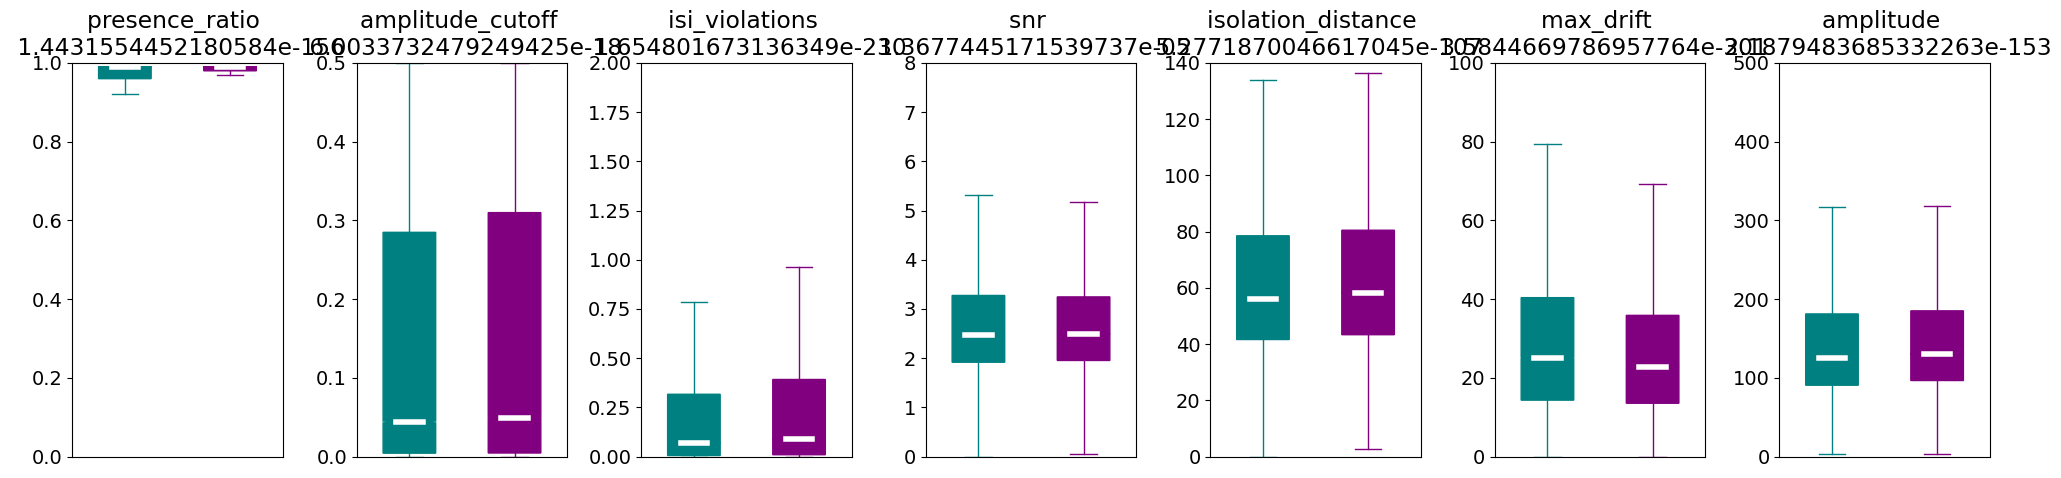

In [359]:
metrics = ['presence_ratio', 
           'amplitude_cutoff', 
           'isi_violations', 
           'snr', 
           'isolation_distance',
           'max_drift', 
           'amplitude']

ranges = [
          [0,1],
          [0,0.5],
          [0,2],
          [0,8],
          [0,140],
          [0, 100],
          [0, 500]]



fig, ax = plt.subplots(1, len(metrics))
fig.set_size_inches([20, 5])
dg_color = 'teal'
vbn_color = 'purple'

for idx, metric in enumerate(metrics):
    
    dg_data = dg_good[metric].values
    print(f'{metric} DG nan: {np.sum(np.isnan(dg_data))}')

    dg_data = dg_data[np.invert(np.isnan(dg_data))]

    
    vbn_data = vbn_good[metric].values
    print(f'{metric} VBN nan: {np.sum(np.isnan(dg_data))}')
    
    vbn_data = vbn_data[np.invert(np.isnan(vbn_data))]

    
    for idata, (data, color) in enumerate(zip([dg_data, vbn_data], [dg_color, vbn_color])):
        ax[idx].boxplot(data, positions=[idata], notch=True, patch_artist=True,
                boxprops=dict(facecolor=color, color=color),
                capprops=dict(color=color),
                whiskerprops=dict(color=color),
                flierprops=dict(color=color, markeredgecolor=color),
                medianprops=dict(color='w',lw=4),
                showfliers=False,
                widths = 0.5
                )

    for label, data in zip(['dg', 'vbn'], [dg_data, vbn_data]):
        CI = bootstrap_median_CI(data, num_iterations=10)
        #print(f'{label} {metric}: median {np.median(data)} +/- sem {1.253*np.std(data)/len(data)**0.5}') #formula for approximating standard error of median
        print(f'{label} {metric}: median {np.median(data)} CI {CI}') #formula for approximating standard error of median
    
    pval = mannwhitneyu(dg_data, vbn_data, nan_policy='omit')[1]
    print(f'{metric} pval: {pval}')
#     _ = plt.subplot(len(metrics),1,idx+1)
#     _ = plt.boxplot([dg_data, vbn_data], showfliers=False, showcaps=False, vert=False)
#     #_ = plt.ylim([0.8,1.2])
    ax[idx].set_ylim(ranges[idx])
    
    ax[idx].set_title(f'{metric} \n {pval}')
    ax[idx].xaxis.set_visible(False)
plt.tight_layout()

fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 'dg_vbn_metrics_comparison.pdf'))

In [243]:
#dg_good = dg_good[(dg_good['isi_violations']<1)&(dg_good['amplitude_cutoff']<0.1)&(dg_good['presence_ratio']>0.9)]

In [195]:
count_unique = lambda x: len(np.unique(x))

In [259]:
unit_counts = dg_good.dropna(subset='session_type').pivot_table(index=['session_type', 'session', 'probe_id', 'name'], values=['probe_channel_number'], aggfunc=max)

In [260]:
unit_counts.loc['EPHYS_1', 1174553025]
unit_counts.reset_index().groupby('session_type').median()

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_84628\4257074669.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unit_counts.reset_index().groupby('session_type').median()


session  probe_id  probe_channel_number
session_type                                              
EPHYS_1       1.200260e+09     336.0                 305.0
EPHYS_2       1.201558e+09     303.5                 305.5
EPHYS_3       1.203575e+09     296.0                 305.0
EPHYS_4       1.195037e+09     236.0                 305.0

In [173]:
#vbn_master_units = pd.read_csv(r"\\allen\programs\mindscope\workgroups\np-behavior\vbn_data_release\supplemental_tables\master_units_with_responsiveness.csv")

In [174]:
#vbn_good = vbn_master_units[vbn_master_units['quality']=='good']

In [362]:
vbn_unit_counts = vbn_good.pivot_table(index=['session_number', 'ecephys_session_id', 'ecephys_probe_id'], values=['amplitude'], aggfunc=len)

In [363]:
vbn_day_counts = [vbn_unit_counts.loc[sess_no]['amplitude'].values for sess_no in [1,2]]
len(vbn_day_counts)

2

In [361]:
unit_counts = dg_good.dropna(subset='session_type').pivot_table(index=['mouse_id', 'name', 'session_type'], values=['amplitude'], aggfunc=len)
unit_means = unit_counts.reset_index().groupby('session_type').mean()
unit_sems = unit_counts.reset_index().groupby('session_type').sem()

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_84628\4103718592.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unit_means = unit_counts.reset_index().groupby('session_type').mean()
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_84628\4103718592.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unit_sems = unit_counts.reset_index().groupby('session_type').sem()


In [342]:
unit_counts.reset_index().groupby('session_type').median()

mouse_id  probe_id  amplitude
session_type                               
EPHYS_1       623322.0     336.0      314.0
EPHYS_2       623320.5     303.5      305.5
EPHYS_3       623322.0     296.0      295.0
EPHYS_4       615048.0     236.0      303.0

[  0. -36. -29. -35.]


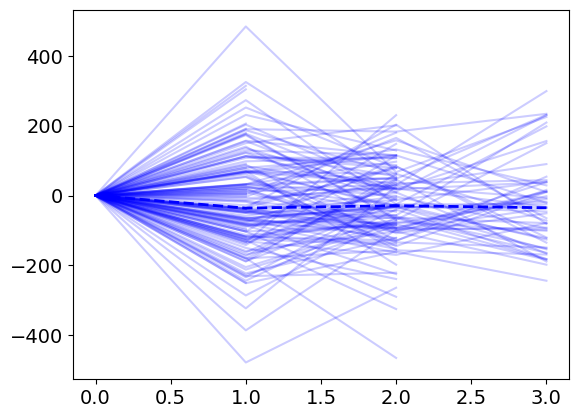

In [357]:
data = []
for _, _df in dg_good.groupby('mouse_id'):
    for _, group_df in _df.groupby('name'):
        num_good_units_by_day = group_df.pivot_table(index='session_type', values='amplitude', aggfunc=len)['amplitude'].values
        a = np.full(4, np.nan)
        a[:len(num_good_units_by_day)] = (num_good_units_by_day - num_good_units_by_day[0])
        data.append(a)
data = np.array(data)
plt.plot(data.T, color='b', alpha=0.2)
plt.plot(np.nanmedian(data, axis=0), color='b', linestyle='--', lw=2)
print(np.nanmedian(data, axis=0))


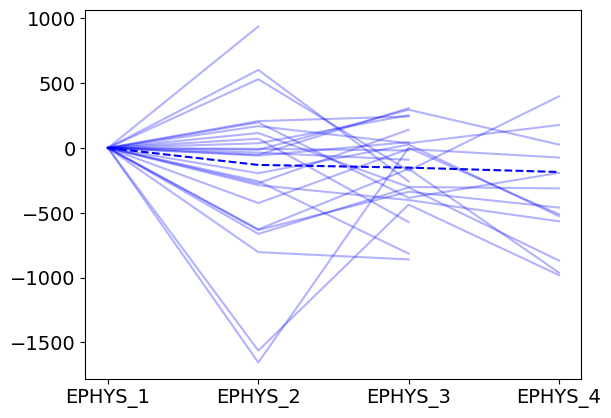

In [340]:
for mouse in unit_counts.index.get_level_values(0).unique():

    mouse_data = unit_counts.loc[mouse]
    plt.plot(mouse_data['amplitude'].values - mouse_data['amplitude'].values[0], 'b', alpha=0.3)

medians = unit_counts.reset_index().groupby('session_type')['amplitude'].median()
medians = medians - medians[0]
plt.plot(medians, '--b')

In [262]:
unit_counts[unit_counts['amplitude']<10].index.get_level_values(2)

Int64Index([], dtype='int64', name='probe_id')

In [263]:
day_counts = [unit_counts.loc[stim]['amplitude'].values for stim in ['EPHYS_1', 'EPHYS_2', 'EPHYS_3', 'EPHYS_4']]


In [370]:
from statsmodels.stats.multitest import multipletests

In [371]:
multipletests?

Signature:
multipletests(
    pvals,
    alpha=0.05,
    method='hs',
    is_sorted=False,
    returnsorted=False,
)
Docstring:
Test results and p-value correction for multiple tests

Parameters
----------
pvals : array_like, 1-d
    uncorrected p-values.   Must be 1-dimensional.
alpha : float
    FWER, family-wise error rate, e.g. 0.1
method : str
    Method used for testing and adjustment of pvalues. Can be either the
    full name or initial letters. Available methods are:

    - `bonferroni` : one-step correction
    - `sidak` : one-step correction
    - `holm-sidak` : step down method using Sidak adjustments
    - `holm` : step-down method using Bonferroni adjustments
    - `simes-hochberg` : step-up method  (independent)
    - `hommel` : closed method based on Simes tests (non-negative)
    - `fdr_bh` : Benjamini/Hochberg  (non-negative)
    - `fdr_by` : Benjamini/Yekutieli (negative)
    - `fdr_tsbh` : two stage fdr correction (non-negative)
    - `fdr_tsbky` : two stage fdr cor

In [373]:
corrected_pvals

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]),
 array([1.        , 0.93568706, 0.93568706, 0.93568706, 0.93568706,
        1.        , 0.93568706, 0.95715012, 0.93568706, 0.93568706,
        1.        , 1.        , 0.93568706, 0.95715012, 1.        ,
        1.        ]),
 0.0032006977101884937,
 0.003125)

In [377]:
pval = scipy.stats.kruskal(*(vbn_day_counts+day_counts), nan_policy='omit')
print(f'VBN pval for unit counts over days: {pval}')

pvals = []
for ivbn, vbnday in enumerate(vbn_day_counts):
    for idg, dgday in enumerate(day_counts):
        pval = scipy.stats.kruskal(vbnday, dgday, nan_policy='omit')[1]
        pvals.append(pval)

corrected_pvals = multipletests(pvals, method='fdr_bh')
count = 0
for ivbn, vbnday in enumerate(vbn_day_counts):
    for idg, dgday in enumerate(day_counts):
        pval = scipy.stats.kruskal(vbnday, dgday, nan_policy='omit')
        print(f'VBN day {ivbn} vs DG day {idg} pval for unit counts over days: {corrected_pvals[1][count]} sig: {corrected_pvals[0][count]}')
        count += 1

print ('DG')

pvals = []
for idg1, dgday1 in enumerate(day_counts):
    for idg, dgday in enumerate(day_counts):
        pval = scipy.stats.kruskal(dgday1, dgday, nan_policy='omit')[1]
        pvals.append(pval)

corrected_pvals = multipletests(pvals, method='fdr_bh')
count = 0
for idg1, dgday1 in enumerate(day_counts):
    for idg, dgday in enumerate(day_counts):
        print(f'DG day {idg1} vs DG day {idg} pval for unit counts over days: {corrected_pvals[1][count]} sig: {corrected_pvals[0][count]}')
        count += 1

VBN pval for unit counts over days: KruskalResult(statistic=109.2264015827727, pvalue=5.969957541916541e-22)
VBN day 0 vs DG day 0 pval for unit counts over days: 0.7836807837603376 sig: False
VBN day 0 vs DG day 1 pval for unit counts over days: 0.23904809706916794 sig: False
VBN day 0 vs DG day 2 pval for unit counts over days: 0.03180530230083644 sig: True
VBN day 0 vs DG day 3 pval for unit counts over days: 0.11138836427056721 sig: False
VBN day 1 vs DG day 0 pval for unit counts over days: 8.734011354203367e-08 sig: True
VBN day 1 vs DG day 1 pval for unit counts over days: 7.575076326681654e-06 sig: True
VBN day 1 vs DG day 2 pval for unit counts over days: 5.7394585365528666e-05 sig: True
VBN day 1 vs DG day 3 pval for unit counts over days: 0.0014218085620447659 sig: True
DG
DG day 0 vs DG day 0 pval for unit counts over days: 1.0 sig: False
DG day 0 vs DG day 1 pval for unit counts over days: 0.9356870629543095 sig: False
DG day 0 vs DG day 2 pval for unit counts over days: 0

In [378]:
pval = scipy.stats.kruskal(*day_counts, nan_policy='omit')
print(f'DG pval for unit counts over days: {pval}')

DG pval for unit counts over days: KruskalResult(statistic=2.4899205554660426, pvalue=0.47711541905510646)


stim: 642504.0 num sessions: 129 median314.0
stim: 642504.0 num sessions: 126 median305.5
stim: 642504.0 num sessions: 121 median295.0
stim: 642504.0 num sessions: 91 median303.0
stim: 0 num sessions: 459 median321.0
stim: 1 num sessions: 446 median261.0


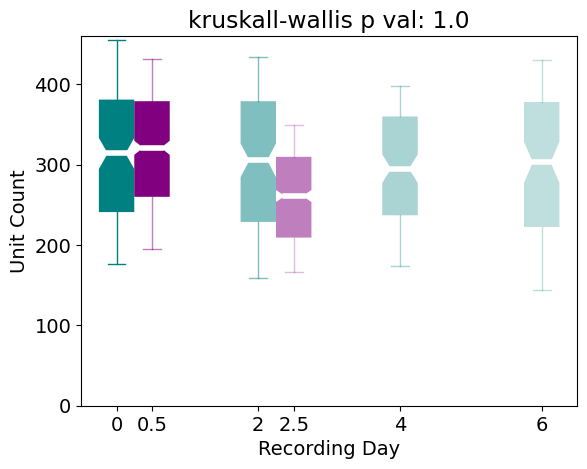

In [366]:
fig, ax = plt.subplots()
color = 'teal'
for istim, counts in enumerate(day_counts):
    #counts = unit_counts.loc[stim]['amplitude'].values
    ax.boxplot(counts, positions=[2*istim], notch=True, patch_artist=True, whis=(10,90),
                boxprops=dict(facecolor=color, linewidth=0, color=color, alpha=1/(istim+1)),
                capprops=dict(color=color, alpha=1/(istim+1)),
                whiskerprops=dict(color=color, alpha=1/(istim+1)),
                medianprops=dict(color='w',lw=4),
                showfliers=False,
                widths = 0.5
                )
    print(f'stim: {stim} num sessions: {len(counts)} median{np.median(counts)}')

color = 'purple'
for istim, counts in enumerate(vbn_day_counts):
    #counts = unit_counts.loc[stim]['amplitude'].values
    ax.boxplot(counts, positions=[2*istim+0.5], notch=True, patch_artist=True, whis=(10,90),
                boxprops=dict(facecolor=color, linewidth=0, color=color, alpha=1/(istim+1)),
                capprops=dict(color=color, alpha=0.5/(istim+1)),
                whiskerprops=dict(color=color, alpha=0.5/(istim+1)),
                medianprops=dict(color='w',lw=4),
                showfliers=False,
                widths = 0.5
                )
    print(f'stim: {istim} num sessions: {len(counts)} median{np.median(counts)}')


ax.set_ylabel('Unit Count')
ax.set_xlabel('Recording Day')
ax.set_title(f'kruskall-wallis p val: {pval[1]}')
ax.set_ylim([0, 460])
fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
                         'unit_yield_by_day_corrected_for_phantom_insertions.pdf'))

In [367]:
firing_rate_means = dg_good[~dg_good['session_type'].str.contains('EPHYS_day_0')].pivot_table(index='session_type', values='firing_rate', aggfunc = ['median', 'sem'])
firing_rate_means

median         sem
             firing_rate firing_rate
session_type                        
EPHYS_1         3.082419    0.040270
EPHYS_2         3.188836    0.038387
EPHYS_3         3.448151    0.039856
EPHYS_4         3.105315    0.046831

In [368]:
firing_rate_by_stim = dg_good.pivot_table(index=['session_type', 'mouse_id', 'session'], values=['firing_rate'], aggfunc=('median', 'sem', 'count'))
firing_rate_by_stim = firing_rate_by_stim['firing_rate', 'median'].groupby('session_type').agg(list)

In [379]:
pval = scipy.stats.kruskal(*firing_rate_by_stim, nan_policy='omit')
print(pval)

KruskalResult(statistic=4.017936882109893, pvalue=0.25953377336575006)


In [380]:
vbn_firing_rate_by_session =  vbn_good.pivot_table(index='session_number', values='firing_rate',aggfunc=('median', 'sem', 'count'))
vbn_firing_rate_by_session

count    median       sem
session_number                            
1               146294  3.269025  0.023042
2               115883  3.557930  0.025805

stim: EPHYS_1 num sessions: 23
stim: EPHYS_2 num sessions: 24
stim: EPHYS_3 num sessions: 22
stim: EPHYS_4 num sessions: 18


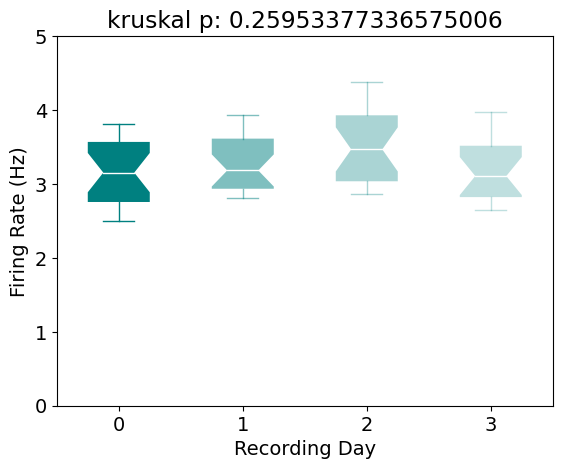

In [381]:
fig, ax = plt.subplots()
color = 'teal'
for istim, stim in enumerate(['EPHYS_1', 'EPHYS_2', 'EPHYS_3', 'EPHYS_4']):
    #firing_rates = dg_good[dg_good['session_type']==stim]['firing_rate'].values
    firing_rates = firing_rate_by_stim[stim]
    ax.boxplot(firing_rates, positions=[istim], notch=True, patch_artist=True, whis=(10,90),
                boxprops=dict(facecolor=color, linewidth=0, color=color, alpha=1/(istim+1)),
                capprops=dict(color=color, alpha=1/(istim+1)),
                whiskerprops=dict(color=color, alpha=1/(istim+1)),
                medianprops=dict(color='w',lw=1),
                showfliers=False,
                widths = 0.5
                )
    print(f'stim: {stim} num sessions: {len(firing_rates)}')
    #ax.violinplot(firing_rates, positions=[istim])
ax.set_ylabel('Firing Rate (Hz)')
ax.set_xlabel('Recording Day')
ax.set_ylim([0, 5])
ax.set_title(f'kruskal p: {pval[1]}')
fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
                         'firing_rates_by_day.pdf'))

## RF stats across days

In [382]:
vbn_good['is_sig_rf']

KeyError: 'is_sig_rf'

In [383]:
all_units = dg_good

In [384]:
all_units['is_sig_rf'] = all_units['p_value_rf'].values < 0.01
# all_units.pivot_table(index=['structure_acronym'], values=['is_sig_rf'], aggfunc=['mean', 'count']).to_csv(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
#                          'fraction_rf_by_area.pdf'))

In [385]:
v1_units = all_units[(all_units['isi_label']=='VISp')]

In [279]:
v1_units

Unnamed: 0      id  PT_ratio   amplitude  amplitude_cutoff  \
5567          6872   15881  0.267478   75.221445          0.229255   
5568          6874   15883  1.253049  194.111775          0.001458   
5569          6876   15884  2.305378   75.370327          0.160736   
5570          6877   15885  0.324673  131.006168          0.003129   
5571          6878   15886  0.383657  101.280368          0.500000   
...            ...     ...       ...         ...               ...   
143303      200567  190927  0.602545   58.375632          0.238419   
143304      200569  190972  0.513129   81.105765          0.180844   
143305      200570  190929  0.399568  215.977572          0.000625   
143306      200578  190987  0.413951  150.356939          0.035995   
143307      200585  190975  0.333281  347.835906          0.025089   

        cluster_id  cumulative_drift   d_prime  firing_rate isi_label  ...  \
5567           280            357.23  0.000000     3.692950      VISp  ...   
5568           282            122.19  7.892023     1.817335      VISp  ...   
5569           284            302.73  3.406734    11.009294      VISp  ...   
5570           285            107.18  6.024271     6.890119      VISp  ...   
5571           286            214.52  2.639123     4.454725      VISp  ...   
...            ...               ...       ...          ...       ...  ...   
143303         262             74.90  2.202178     0.135646      VISp  ...   
143304         307             80.11  2.660195     0.216283      VISp  ...   
143305         264              7.89  4.817430     0.067578      VISp  ...   
143306         322              9.49  0.000000     0.063987      VISp  ...   
143307         310             10.56  0.000000     0.083738      VISp  ...   

        has_lfp  Unnamed: 0_probes  id_probes    name  \
5567       True                 20         43  probeC   
5568       True                 20         43  probeC   
5569       True                 20         43  probeC   
5570       True                 20         43  probeC   
5571       True                 20         43  probeC   
...         ...                ...        ...     ...   
143303     True                580        547  probeD   
143304     True                580        547  probeD   
143305     True                580        547  probeD   
143306     True                580        547  probeD   
143307     True                580        547  probeD   

                       location  sampling_rate  lfp_sampling_rate  \
5567    See electrode locations   30000.224639                NaN   
5568    See electrode locations   30000.224639                NaN   
5569    See electrode locations   30000.224639                NaN   
5570    See electrode locations   30000.224639                NaN   
5571    See electrode locations   30000.224639                NaN   
...                         ...            ...                ...   
143303  See electrode locations   30000.093436                NaN   
143304  See electrode locations   30000.093436                NaN   
143305  See electrode locations   30000.093436                NaN   
143306  See electrode locations   30000.093436                NaN   
143307  See electrode locations   30000.093436                NaN   

        has_lfp_data  session_probes inserted  
5567           False      1178693650     True  
5568           False      1178693650     True  
5569           False      1178693650     True  
5570           False      1178693650     True  
5571           False      1178693650     True  
...              ...             ...      ...  
143303         False      1232954220     True  
143304         False      1232954220     True  
143305         False      1232954220     True  
143306         False      1232954220     True  
143307         False      1232954220     True  

[6040 rows x 78 columns]

In [280]:
# v1_units = all_units[(all_units['isi_label']=='VISp')]

# quality_filter = ((v1_units['isi_violations'] < 0.5) & 
#                  (v1_units['amplitude_cutoff']< 0.1) & 
#                  (v1_units['presence_ratio'] > 0.95) & 
#                  (v1_units['quality'] == 'good') &
#                  ([True]*len(v1_units)))

# v1_units = v1_units[quality_filter]

In [386]:
v1_units['is_sig_rf'] = v1_units['p_value_rf'].values < 0.05

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_84628\3923304705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v1_units['is_sig_rf'] = v1_units['p_value_rf'].values < 0.05


In [387]:
v1_units.pivot_table(index=['mouse_id','session_type'], values='is_sig_rf', aggfunc=('mean', 'std', 'count'))

count      mean       std
mouse_id session_type                           
607660.0 EPHYS_1         139  0.892086  0.311393
         EPHYS_2         144  0.847222  0.361029
         EPHYS_3         119  0.957983  0.201476
         EPHYS_4         120  0.933333  0.250490
608671.0 EPHYS_1         110  0.836364  0.371638
         EPHYS_2         210  0.819048  0.385899
         EPHYS_3         111  0.837838  0.370271
         EPHYS_4         126  0.761905  0.427618
608672.0 EPHYS_1         109  0.862385  0.346086
         EPHYS_2         123  0.731707  0.444883
         EPHYS_3         104  0.817308  0.388285
         EPHYS_4         138  0.768116  0.423573
612090.0 EPHYS_2          83  0.566265  0.498602
         EPHYS_3         126  0.928571  0.258567
         EPHYS_4         131  0.916031  0.278407
614547.0 EPHYS_4         134  0.567164  0.497328
614608.0 EPHYS_1         132  0.916667  0.277438
         EPHYS_2         153  0.803922  0.398332
615047.0 EPHYS_2         131  0.908397  0.289572
         EPHYS_4          88  0.886364  0.319188
615048.0 EPHYS_2          75  0.893333  0.310768
         EPHYS_4          90  0.866667  0.341839
615563.0 EPHYS_1         183  0.786885  0.410632
         EPHYS_3         107  0.934579  0.248430
         EPHYS_4          45  0.933333  0.252262
623319.0 EPHYS_3         137  0.445255  0.498818
623322.0 EPHYS_1          78  0.897436  0.305352
         EPHYS_3         139  0.863309  0.344763
623784.0 EPHYS_1         150  0.926667  0.261556
         EPHYS_2         123  0.829268  0.377813
         EPHYS_3          74  0.959459  0.198569
         EPHYS_4          86  0.813953  0.391427
623786.0 EPHYS_1         111  0.864865  0.343418
626279.0 EPHYS_1         138  0.913043  0.282798
         EPHYS_3         252  0.825397  0.380383
         EPHYS_4          80  0.925000  0.265053
632295.0 EPHYS_2         124  0.822581  0.383573
         EPHYS_4         169  0.786982  0.410657
636740.0 EPHYS_1         266  0.522556  0.500432
         EPHYS_2         139  0.517986  0.501484
         EPHYS_3         159  0.861635  0.346373
637483.0 EPHYS_2         312  0.512821  0.500639
638387.0 EPHYS_1          94  0.521277  0.502226
         EPHYS_3          82  0.829268  0.378590
640890.0 EPHYS_1         186  0.580645  0.494785
         EPHYS_3         110  0.818182  0.387460

In [315]:
v1_units[v1_units['mouse_id']==640890].value_counts(['session_type', 'probe_id', 'name'])

session_type  probe_id  name  
EPHYS_1       535       probeD    69
EPHYS_3       547       probeD    42
dtype: int64

In [ ]:
v1_units['anterior_posterior_ccf_coordinate']

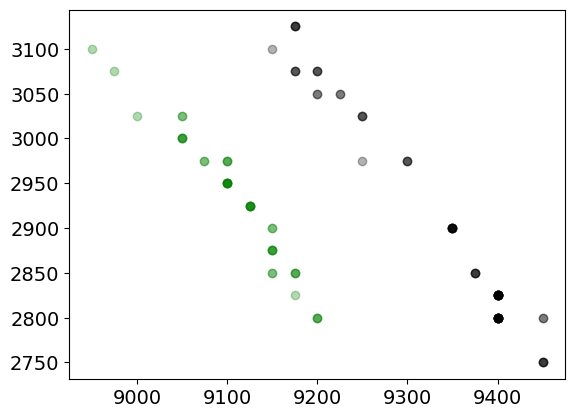

In [316]:
colors = ['k', 'r', 'g']
for istim, stim in enumerate(['EPHYS_1', 'EPHYS_2', 'EPHYS_3']):
    plt.plot(v1_units[(v1_units['mouse_id']==640890)&(v1_units['session_type']==stim)]['anterior_posterior_ccf_coordinate'].values,
         v1_units[(v1_units['mouse_id']==640890)&(v1_units['session_type']==stim)]['left_right_ccf_coordinate'].values, colors[istim]+'o', alpha=0.3)

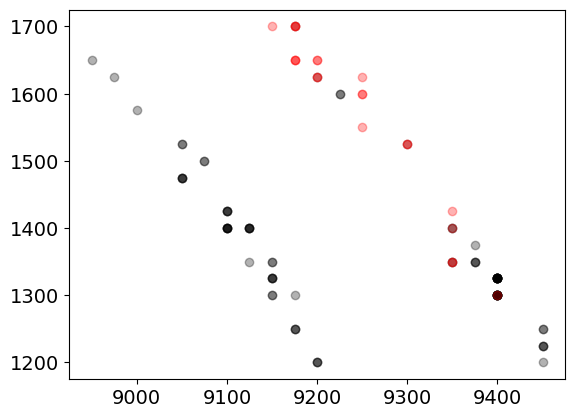

In [319]:
# plt.plot(v1_units[v1_units['is_sig_rf']]['left_right_ccf_coordinate'].values,
#          v1_units[v1_units['is_sig_rf']]['anterior_posterior_ccf_coordinate'].values, 'ko', alpha=0.3)

# plt.plot(v1_units[~v1_units['is_sig_rf']]['left_right_ccf_coordinate'].values,
#          v1_units[~v1_units['is_sig_rf']]['anterior_posterior_ccf_coordinate'].values, 'ro', alpha=0.3)

plt.plot(v1_units[(v1_units['mouse_id']==640890)&(v1_units['is_sig_rf'])]['anterior_posterior_ccf_coordinate'].values,
         v1_units[(v1_units['mouse_id']==640890)&(v1_units['is_sig_rf'])]['dorsal_ventral_ccf_coordinate'].values, 'ko', alpha=0.3)

plt.plot(v1_units[(v1_units['mouse_id']==640890)&(~v1_units['is_sig_rf'])]['anterior_posterior_ccf_coordinate'].values,
         v1_units[(v1_units['mouse_id']==640890)&(~v1_units['is_sig_rf'])]['dorsal_ventral_ccf_coordinate'].values, 'ro', alpha=0.3)

# plt.plot(v1_units[v1_units['mouse_id']==614608]['left_right_ccf_coordinate'].values,
#          v1_units[v1_units['mouse_id']==614608]['anterior_posterior_ccf_coordinate'].values, 'go', alpha=0.3)


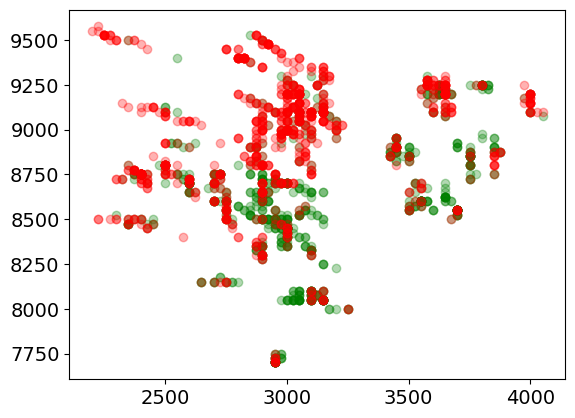

In [296]:
plt.plot(v1_units[(v1_units['is_sig_rf'])&(v1_units['elevation_rf']<10)]['left_right_ccf_coordinate'].values,
         v1_units[(v1_units['is_sig_rf'])&(v1_units['elevation_rf']<10)]['anterior_posterior_ccf_coordinate'].values, 'go', alpha=0.3)

plt.plot(v1_units[(v1_units['is_sig_rf'])&(v1_units['elevation_rf']>10)]['left_right_ccf_coordinate'].values,
         v1_units[(v1_units['is_sig_rf'])&(v1_units['elevation_rf']>10)]['anterior_posterior_ccf_coordinate'].values, 'ro', alpha=0.3)

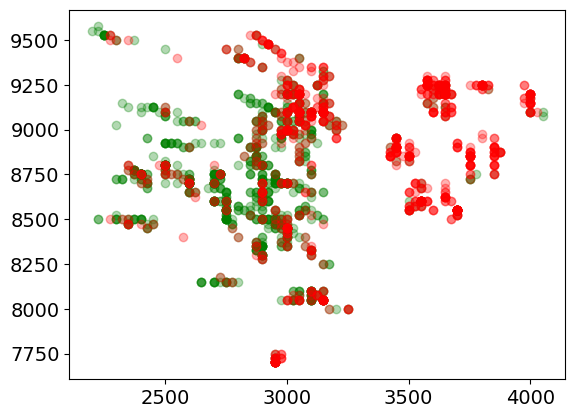

In [297]:
plt.plot(v1_units[(v1_units['is_sig_rf'])&(v1_units['azimuth_rf']<30)]['left_right_ccf_coordinate'].values,
         v1_units[(v1_units['is_sig_rf'])&(v1_units['azimuth_rf']<30)]['anterior_posterior_ccf_coordinate'].values, 'go', alpha=0.3)

plt.plot(v1_units[(v1_units['is_sig_rf'])&(v1_units['azimuth_rf']>30)]['left_right_ccf_coordinate'].values,
         v1_units[(v1_units['is_sig_rf'])&(v1_units['azimuth_rf']>30)]['anterior_posterior_ccf_coordinate'].values, 'ro', alpha=0.3)

In [285]:
v1_center = vbn_good[vbn_good['structure_acronym']=='VISp'][['anterior_posterior_ccf_coordinate', 'left_right_ccf_coordinate']].mean()

In [286]:
v1_ap_center = v1_center['anterior_posterior_ccf_coordinate']
v1_lf_center = 456*25 - v1_center['left_right_ccf_coordinate'] 

In [287]:
v1_lf_center

3676.514567795246

In [288]:
def distance(ap, lr):
    return ((ap-v1_ap_center)**2 + (lr-v1_lf_center)**2)**0.5
    
distance_from_v1_center = v1_units.apply(lambda row: distance(row['anterior_posterior_ccf_coordinate'],
                                                             row['left_right_ccf_coordinate']), axis=1)

v1_units['distance_from_v1_center'] = distance_from_v1_center

In [289]:
len(v1_units[v1_units['distance_from_v1_center']<500])

598

In [388]:
fraction_v1_insertions_with_rfs_by_stim = v1_units.pivot_table(index=['session_type', 'mouse_id', 'session'], values=['is_sig_rf', 'distance_from_v1_center'], aggfunc=('mean', 'sem', 'count'))

KeyError: 'distance_from_v1_center'

In [291]:
fraction_v1_insertions_with_rfs_by_stim

distance_from_v1_center               \
                                                   count         mean   
session_type mouse_id session                                           
EPHYS_1      607660.0 1182427414                      59   696.515602   
             608671.0 1177900858                      47   808.554152   
             608672.0 1174553025                      36   644.166094   
             614608.0 1187475832                      70   545.317343   
             615563.0 1194411467                      82  1288.271048   
             623322.0 1200260055                      30   637.868967   
             623784.0 1202438738                      75   976.537778   
             623786.0 1210343162                      56  1094.794053   
             626279.0 1214217748                      59   707.992072   
             636740.0 1226010097                     105   809.586273   
             638387.0 1229429400                      34  1217.055433   
             640890.0 1232430325                      69   898.143525   
EPHYS_2      607660.0 1182628226                      57   290.870799   
             608671.0 1178173272                      73   680.506480   
             608672.0 1174790219                      35   376.738985   
             612090.0 1179911454                      26   854.568752   
             614608.0 1187668018                      74  1019.698154   
             615047.0 1191131853                      50   963.888761   
             615048.0 1197725774                      26   695.073061   
             623784.0 1202644967                      48    99.814961   
             632295.0 1218795542                      50   870.055499   
             636740.0 1226251663                      44  1458.189261   
             637483.0 1227855488                     124   543.871303   
EPHYS_3      607660.0 1182871514                      42   799.772557   
             608671.0 1178460518                      30   799.565549   
             608672.0 1175067685                      45   724.111959   
             612090.0 1180107381                      59   321.371742   
             615563.0 1194850630                      45  1176.655745   
             623319.0 1208664393                      55   614.173099   
             623322.0 1200659846                      60   333.543372   
             623784.0 1203574877                      29  1007.867368   
             626279.0 1214566710                     107   946.886314   
             636740.0 1226528572                      75   995.296839   
             638387.0 1229887685                      31   812.081273   
             640890.0 1232954220                      42   778.282626   
EPHYS_4      607660.0 1183071525                      56   339.594374   
             608671.0 1178693650                      61   237.374868   
             608672.0 1175253205                      40   339.902235   
             612090.0 1180266229                      64   823.849296   
             614547.0 1181731440                      59  1381.713879   
             615047.0 1191631184                      37   992.426745   
             615048.0 1198130743                      39   813.952333   
             615563.0 1195036753                      18   263.804188   
             623784.0 1204636084                      39   187.048736   
             626279.0 1214740195                      33  1185.294041   
             632295.0 1219401111                      74   726.833119   

                                            is_sig_rf                      
                                        sem     count      mean       sem  
session_type mouse_id session                                              
EPHYS_1      607660.0 1182427414   1.805722        59  0.966102  0.023762  
             608671.0 1177900858   1.661792        47  0.914894  0.041142  
             608672.0 1174553025   5.696522        36  1.000000  0.000000  

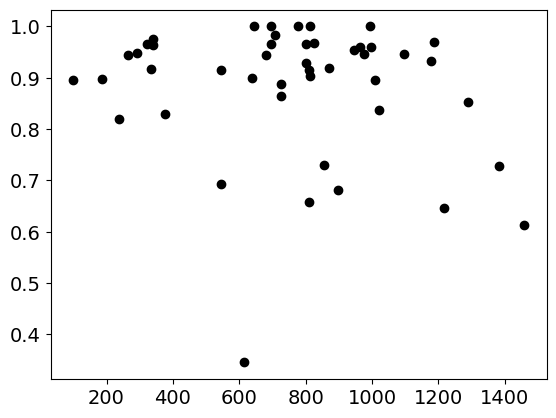

In [292]:
plt.plot(fraction_v1_insertions_with_rfs_by_stim['distance_from_v1_center', 'mean'],
        fraction_v1_insertions_with_rfs_by_stim['is_sig_rf', 'mean'], 'ko')

In [389]:
fractionrfs = [fraction_v1_insertions_with_rfs_by_stim.loc[stim]['is_sig_rf', 'mean'].values for stim in ['EPHYS_1', 'EPHYS_2', 'EPHYS_3', 'EPHYS_4']]
pval = scipy.stats.kruskal(*fractionrfs, nan_policy='omit')
print(pval)

KruskalResult(statistic=3.0371183115038374, pvalue=0.3859375932331582)


stim EPHYS_1 num sessions 12
stim EPHYS_2 num sessions 11
stim EPHYS_3 num sessions 12
stim EPHYS_4 num sessions 11


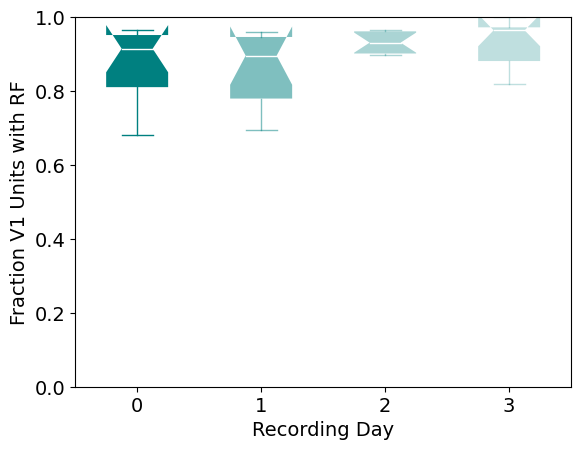

In [390]:
fig, ax = plt.subplots()
for istim, stim in enumerate(['EPHYS_1', 'EPHYS_2', 'EPHYS_3', 'EPHYS_4']):
    fractionrfs = fraction_v1_insertions_with_rfs_by_stim.loc[stim]['is_sig_rf', 'mean'].values
    ax.boxplot(fractionrfs, positions=[istim], notch=True, patch_artist=True, whis=(10,90),
                boxprops=dict(facecolor=color, linewidth=0, color=color, alpha=1/(istim+1)),
                capprops=dict(color=color, alpha=1/(istim+1)),
                whiskerprops=dict(color=color, alpha=1/(istim+1)),
                medianprops=dict(color='w',lw=1),
                showfliers=False,
                widths = 0.5
                )
    print(f'stim {stim} num sessions {len(fractionrfs)}')
    #ax.violinplot(firing_rates, positions=[istim])
ax.set_ylabel('Fraction V1 Units with RF')
ax.set_xlabel('Recording Day')
ax.set_ylim([0, 1])
fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
                         'v1_fraction_rfs_by_day.pdf'))

In [295]:
fraction_v1_insertions_with_rfs_by_stim.loc['EPHYS_1']

distance_from_v1_center                         is_sig_rf  \
                                      count         mean        sem     count   
mouse_id session                                                                
607660.0 1182427414                      59   696.515602   1.805722        59   
608671.0 1177900858                      47   808.554152   1.661792        47   
608672.0 1174553025                      36   644.166094   5.696522        36   
614608.0 1187475832                      70   545.317343   4.049991        70   
615563.0 1194411467                      82  1288.271048   1.978277        82   
623322.0 1200260055                      30   637.868967   4.243640        30   
623784.0 1202438738                      75   976.537778   1.653248        75   
623786.0 1210343162                      56  1094.794053   1.650450        56   
626279.0 1214217748                      59   707.992072   5.532306        59   
636740.0 1226010097                     105   809.586273  27.334953       105   
638387.0 1229429400                      34  1217.055433   6.740724        34   
640890.0 1232430325                      69   898.143525  17.611654        69   

                                         
                         mean       sem  
mouse_id session                         
607660.0 1182427414  0.966102  0.023762  
608671.0 1177900858  0.914894  0.041142  
608672.0 1174553025  1.000000  0.000000  
614608.0 1187475832  0.914286  0.033701  
615563.0 1194411467  0.853659  0.039272  
623322.0 1200260055  0.900000  0.055709  
623784.0 1202438738  0.946667  0.026121  
623786.0 1210343162  0.946429  0.030362  
626279.0 1214217748  0.983051  0.016949  
636740.0 1226010097  0.657143  0.046545  
638387.0 1229429400  0.647059  0.083189  
640890.0 1232430325  0.681159  0.056514

In [97]:
v1_units.pivot_table(index=['session_type'], values='distance_from_v1_center', aggfunc=('mean', 'sem', 'count'))

count        mean        sem
session_type                              
EPHYS_1         722  872.453786   9.488021
EPHYS_2         607  697.330352  15.443801
EPHYS_3         620  772.451061  12.202351
EPHYS_4         520  682.208415  17.194806

NameError: name 'v1_sig_rf' is not defined

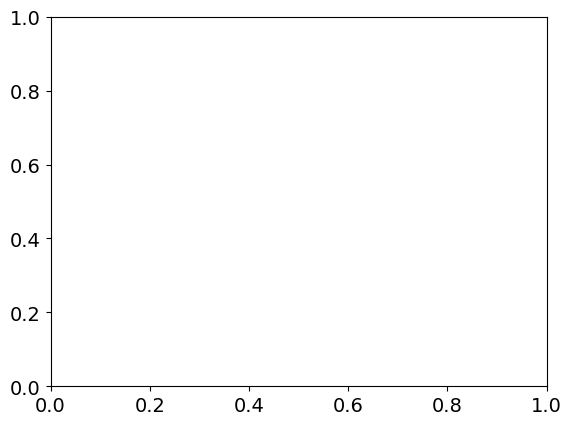

In [98]:
fig, ax = plt.subplots()
c = ax.scatter(v1_sig_rf['left_right_ccf_coordinate'], 
        v1_sig_rf['anterior_posterior_ccf_coordinate'],
        c=v1_sig_rf['azimuth_rf'], cmap='jet', alpha=0.3)
ax.invert_yaxis()
plt.colorbar(c)

fig, ax = plt.subplots()
c = ax.scatter(v1_sig_rf['left_right_ccf_coordinate'], 
        v1_sig_rf['anterior_posterior_ccf_coordinate'],
        c=v1_sig_rf['elevation_rf'], cmap='jet', alpha=0.3)
ax.invert_yaxis()
plt.colorbar(c)

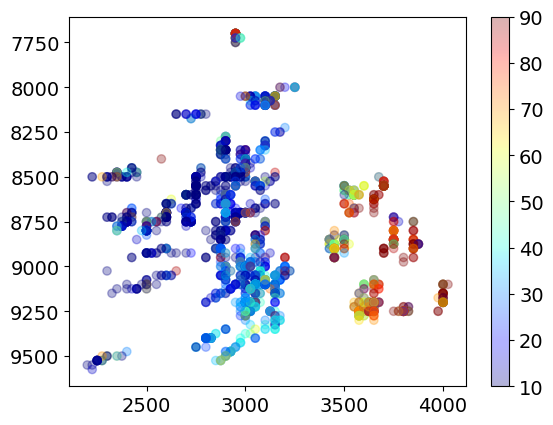

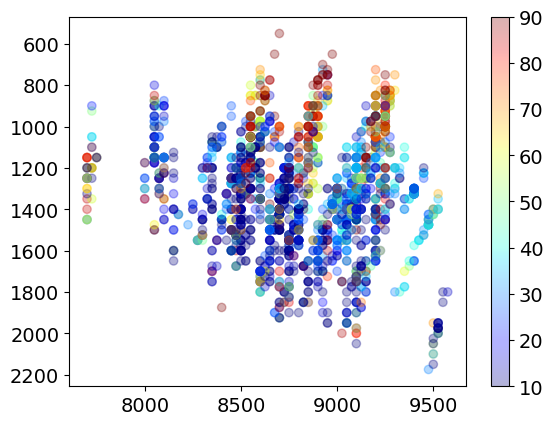

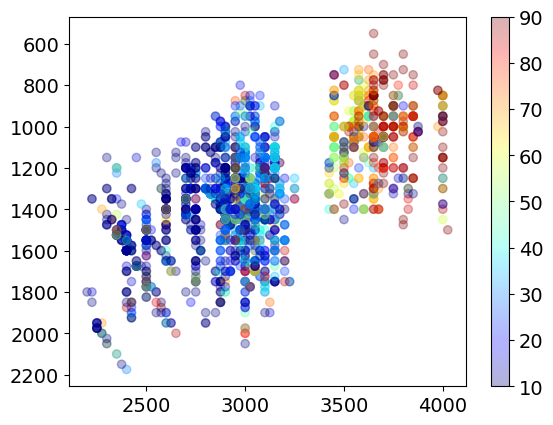

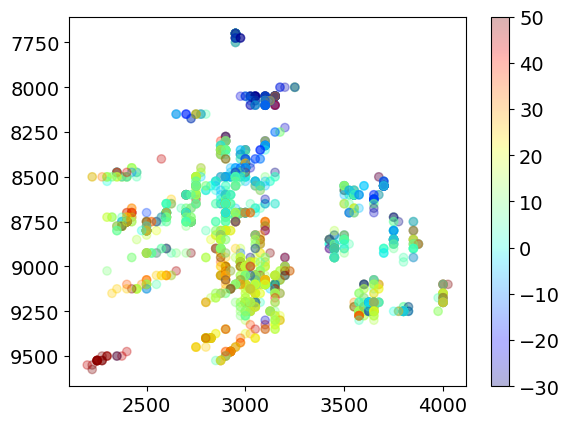

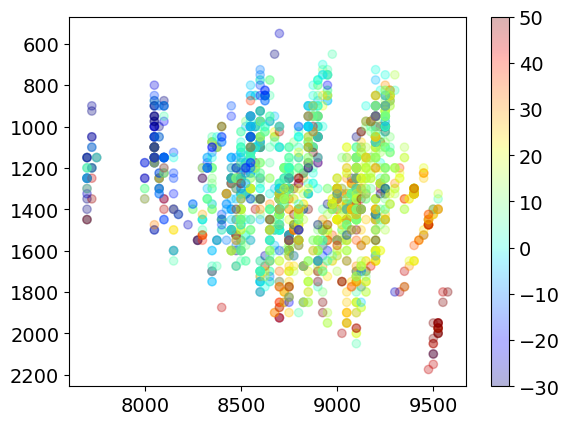

In [299]:
quality_filter = ((all_units['isi_violations'] < 0.5) & 
                 (all_units['amplitude_cutoff']< 0.1) & 
                 (all_units['presence_ratio'] > 0.95) & 
                 (all_units['quality'] == 'good') &
                 ([True]*len(all_units)))

lgn_sig_rf = all_units[(all_units['isi_label']=='VISp')&
                       (all_units['is_sig_rf'])&
                        quality_filter]

fig, ax = plt.subplots()
c = ax.scatter(lgn_sig_rf['left_right_ccf_coordinate'], 
        lgn_sig_rf['anterior_posterior_ccf_coordinate'],
        c=lgn_sig_rf['azimuth_rf'], cmap='jet', alpha=0.3)
ax.invert_yaxis()
plt.colorbar(c)

fig, ax = plt.subplots()
c = ax.scatter(lgn_sig_rf['anterior_posterior_ccf_coordinate'], 
        lgn_sig_rf['dorsal_ventral_ccf_coordinate'],
        c=lgn_sig_rf['azimuth_rf'], cmap='jet', alpha=0.3)
ax.invert_yaxis()
plt.colorbar(c)

fig, ax = plt.subplots()
c = ax.scatter(lgn_sig_rf['left_right_ccf_coordinate'], 
        lgn_sig_rf['dorsal_ventral_ccf_coordinate'],
        c=lgn_sig_rf['azimuth_rf'], cmap='jet', alpha=0.3)
ax.invert_yaxis()
plt.colorbar(c)

fig, ax = plt.subplots()
c = ax.scatter(lgn_sig_rf['left_right_ccf_coordinate'], 
        lgn_sig_rf['anterior_posterior_ccf_coordinate'],
        c=lgn_sig_rf['elevation_rf'], cmap='jet', alpha=0.3)
ax.invert_yaxis()
plt.colorbar(c)

fig, ax = plt.subplots()
c = ax.scatter(lgn_sig_rf['anterior_posterior_ccf_coordinate'], 
        lgn_sig_rf['dorsal_ventral_ccf_coordinate'],
        c=lgn_sig_rf['elevation_rf'], cmap='jet', alpha=0.3)
ax.invert_yaxis()
plt.colorbar(c)

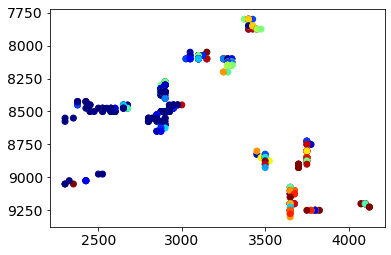

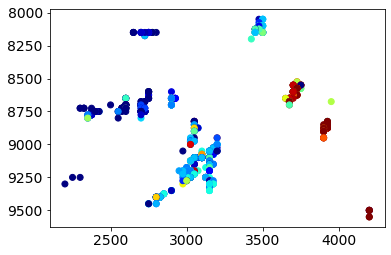

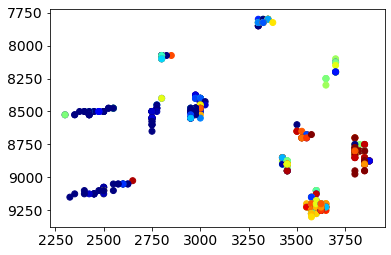

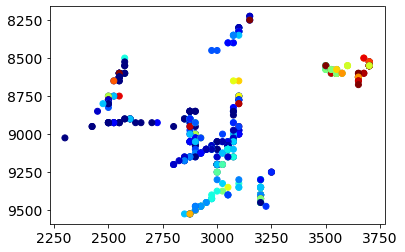

In [770]:
v1_sig_rf = v1_units[v1_units['is_sig_rf']]

for stim in v1_sig_rf['stim'].unique():
    v1_stim_df = v1_sig_rf[v1_sig_rf['stim']==stim]
    fig, ax = plt.subplots()
    ax.scatter(v1_stim_df['left_right_ccf_coordinate'], 
            v1_stim_df['anterior_posterior_ccf_coordinate'],
            c=v1_stim_df['azimuth_rf'], cmap='jet')
    ax.invert_yaxis()

In [752]:
m = all_units[all_units['mouse_id']==632295].pivot_table(index=['stim', 'structure_acronym'], values='amplitude', aggfunc='count')

In [754]:
m.loc['EPHYS_1']

amplitude
structure_acronym           
APN                       61
CA1                      142
CA2                       26
CA3                      162
CL                        30
CP                       104
DG                        92
LD                        10
MGd                       11
MGm                       43
MGv                      116
NOT                       11
No Area                  182
RSPagl2/3                 22
RSPagl5                   39
RT                       111
SSp                      636
SUB                        6
VAL                       42
VISl2/3                    9
VISl4                     25
VISl5                     64
VISl6a                    34
VISl6b                     1
VISp1                     14
VISp2/3                   85
VISp4                     28
VISp5                     16
VISp6a                    20
VISp6b                     4
VL                         1
VPL                       65

In [755]:
all_units.columns

Index(['id', 'PT_ratio', 'amplitude', 'amplitude_cutoff', 'cluster_id',
       'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations',
       'isolation_distance', 'l_ratio', 'local_index', 'max_drift',
       'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio',
       'quality', 'recovery_slope', 'repolarization_slope', 'silhouette_score',
       'snr', 'spread', 'velocity_above', 'velocity_below',
       'waveform_duration', 'session', 'id_channel',
       'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate',
       'filtering', 'left_right_ccf_coordinate', 'probe_channel_number',
       'probe_horizontal_position', 'probe_id', 'probe_vertical_position',
       'structure_acronym', 'session_channel', 'mouse_id', 'genotype', 'date',
       'local_path', 'exp_id', 'project', 'stim', 'regimen', 'pkl_format',
       'probes_inserted', 'Notes', 'NWB File Notes', 'session_id', 'unit_id',
       'azimuth_rf', 'elevation_rf', 'width_rf', 'height_rf', 'a

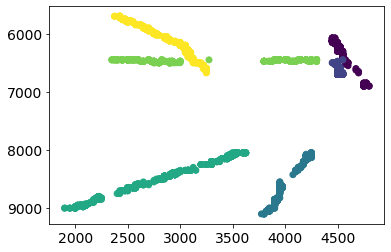

In [759]:
m = all_units[(all_units['mouse_id']==632295)&(all_units['stim']=='EPHYS_1')]
plt.scatter(m['left_right_ccf_coordinate'], m['anterior_posterior_ccf_coordinate'], c=m['probe_id'])
ax = plt.gca()
ax.invert_yaxis()

In [833]:
dynamic_gating_sessions[dynamic_gating_sessions['mouse_id']==608672]

mouse_id           genotype      date  ... Notes NWB File Notes  session_id
15    608672  Sst-IRES-Cre;Ai32  20220502  ...   NaN            NaN  1174553025
16    608672  Sst-IRES-Cre;Ai32  20220503  ...   NaN            NaN  1174790219
17    608672  Sst-IRES-Cre;Ai32  20220504  ...   NaN            NaN  1175067685
18    608672  Sst-IRES-Cre;Ai32  20220505  ...   NaN            NaN  1175253205

[4 rows x 13 columns]

In [930]:
session = DynamicGatingEcephysSession.from_nwb_path(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\nwbs\1175253205\1175253205.nwb")

C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\hdmf\spec\namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\hdmf\utils.py:577: FutureWarning: VectorData.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)
C:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\allensdk_38\lib\site-packages\hdmf\utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


In [949]:
units = session.get_units()
units = units.merge(rf_df, left_on='id', right_on='unit_id')
units['is_sig_rf'] = units['p_value_rf']<0.05

quality_filter = (#(units['isi_violations'] < 0.5) & 
                 #(units['amplitude_cutoff']< 0.1) & 
                 #(units['presence_ratio'] > 0.95) & 
                 (units['quality'] == 'good') &
                 #(units['amplitude'] > 500) &
                 #(units['max_drift'] < 20) &
                 ([True]*len(units)))

good_units = units[quality_filter]
channels = session.get_channels()
good_units = good_units.merge(channels, left_on='peak_channel_id', right_index=True)
good_units = good_units.merge(session.probes, left_on='probe_id', right_index=True)
good_units = good_units[good_units['structure_acronym']!='No Area']

v1_units = good_units[(good_units['structure_acronym'].str.contains('VISp'))&
                     ~good_units['structure_acronym'].str.contains('m') & 
                     good_units['is_sig_rf']]

v1_units['structure_acronym'].value_counts()

VISp4       32
VISp2/3     29
VISp5       24
VISp6a      21
VISpor6a     8
Name: structure_acronym, dtype: int64

In [950]:
units = session.get_units()
units.head()

PT_ratio   amplitude  amplitude_cutoff  cluster_id  ...  spread  velocity_above  velocity_below  waveform_duration
id                                                          ...                                                           
319337  0.487952  290.701710          0.500000           0  ...    40.0        0.206030        0.000000           0.247236
319338  0.655841  422.295315          0.232195           1  ...    50.0        0.000000       -0.343384           0.192295
319339  1.126187  382.760235          0.000849           3  ...    60.0        0.206030        0.000000           0.700503
319340  0.802727  503.825595          0.500000           4  ...    60.0        0.274707       -0.343384           0.164824
319341  0.278906  421.163437          0.500000           7  ...   100.0        2.493619        0.343384           0.260972

[5 rows x 25 columns]

In [932]:
most_common_probe_id = v1_units['probe_id'].value_counts().idxmax()
v1_units = v1_units[v1_units['probe_id']==most_common_probe_id]

In [933]:
spike_times = session.spike_times
stimulus_presentations = session.stimulus_presentations
rf_stim_table = stimulus_presentations[stimulus_presentations['stimulus_name'].str.contains('gabor')]
xs = np.sort(rf_stim_table.position_x.unique()) #positions of gabor along azimuth
ys = np.sort(rf_stim_table.position_y.unique()) #positions of gabor along elevation

In [862]:
#Convenience function to compute the PSTH
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/startTimes.size
    return counts/binSize, bins

def find_rf(spikes, xs, ys):
    unit_rf = np.zeros([ys.size, xs.size])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            stim_times = rf_stim_table[(rf_stim_table.position_x==x)
                                      &(rf_stim_table.position_y==y)]['start_time'].values
            unit_response, bins = makePSTH(spikes, 
                                          stim_times+0.01, 
                                          0.2, binSize=0.001)
            unit_rf[iy, ix] = unit_response.mean()
    return unit_rf


v1_units = v1_units.sort_values(by='dorsal_ventral_ccf_coordinate')
area_rfs = []
for iu, unit in v1_units.iterrows():
    uid = unit['unit_id']
    unit_spike_times = spike_times[uid]
    unit_rf = find_rf(unit_spike_times, xs, ys)
    area_rfs.append(unit_rf)

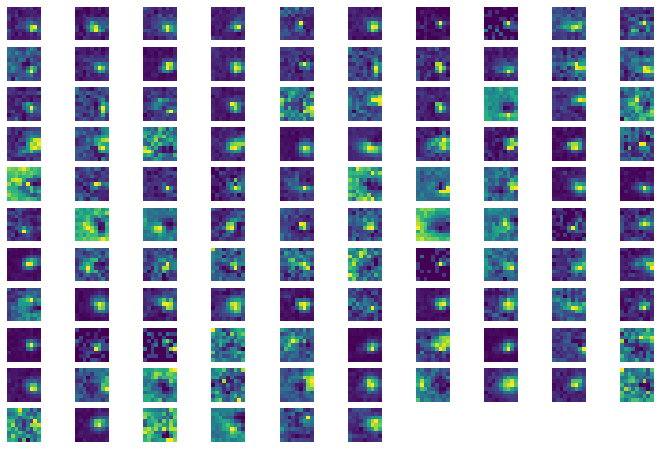

In [863]:
fig, axes = plt.subplots(int(len(area_rfs)/10)+1, 10)
fig.set_size_inches(12, 8)
for irf, rf in enumerate(area_rfs):
    ax_row = int(irf/10)
    ax_col = irf%10
    axes[ax_row][ax_col].imshow(rf, origin='lower')
for ax in axes.flat:
    ax.axis('off')
    
fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
                         'v1_rfs_session_' + str(session.metadata['mouse_id'])+'_'+session.metadata['session_type']+'.pdf'))

In [824]:
v1_units['probe_id'].value_counts()

868    102
867     64
866     35
Name: probe_id, dtype: int64

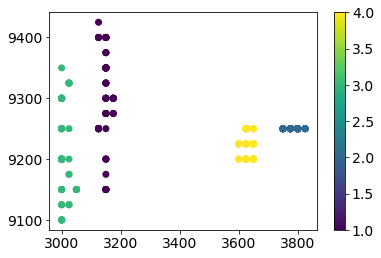

In [885]:
mouse_units = all_units[(all_units['mouse_id']==608672)&
                        (all_units['structure_acronym'].str.contains('VISp'))&
                        (~all_units['structure_acronym'].str.contains('m'))&
                       (all_units['quality']=='good')]

probe_counts = mouse_units.pivot_table(index=['stim', 'probe_id'], values='amplitude', aggfunc='count')
most_common_probes_per_stim = probe_counts.groupby(level=0).idxmax()['amplitude'].values
most_common_probes_per_stim = [m[1] for m in most_common_probes_per_stim]

mouse_units = mouse_units[mouse_units['probe_id'].isin(most_common_probes_per_stim)]

stim_id = [int(s.split('_')[-1]) for s in mouse_units['stim'].values]
c = plt.scatter(mouse_units['left_right_ccf_coordinate'], mouse_units['anterior_posterior_ccf_coordinate'], c=stim_id)
plt.colorbar(c)

In [888]:
mouse_units.pivot_table(index='stim', values=['anterior_posterior_ccf_coordinate', 
                                              'left_right_ccf_coordinate', 
                                              'dorsal_ventral_ccf_coordinate'], aggfunc='median').to_csv(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
                         'v1_rfs_session_' + str(session.metadata['mouse_id'])+'_median_v1_ccf_positions_across_days.csv'))

In [884]:
a.groupby(level=0).idxmax()['amplitude'].values

array([('EPHYS_1', 885), ('EPHYS_2', 890), ('EPHYS_3', 642),
       ('EPHYS_4', 902)], dtype=object)

In [936]:
stimulus_presentations.groupby('stimulus_block').head(1)

active  color  contrast  ...     end_time  temporal_frequency  trials_id
stimulus_presentations_id                           ...                                            
0                            True    NaN       NaN  ...    37.583412                 NaN          0
5195                        False    NaN       NaN  ...  3986.600898                 NaN         -1
5196                        False    NaN       0.8  ...  3986.851099                 4.0         -1
8841                        False    NaN       NaN  ...  5187.605088                 NaN         -1
8842                        False   -1.0       0.8  ...  5187.855304                 NaN         -1

[5 rows x 23 columns]

In [948]:
stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']].value_counts('image_name')

image_name
im087_r-1.0    55
im047_r-1.0    54
im115_r-0.7    54
im115_r-1.0    54
dtype: int64

In [953]:
unit_change_response.shape

(2500,)

In [944]:
stimulus_presentations = session.stimulus_presentations
change_times = stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']]['start_time'].values

# change_times = stimulus_presentations[(stimulus_presentations['stimulus_block']==4)&
#                             (stimulus_presentations['color']==-1)]['start_time'].values


area_change_responses = []
time_before_change = 1
duration = 2.5
for iu, unit in v1_units.iterrows():
    uid = unit['unit_id']
    unit_spike_times = spike_times[uid]
    unit_change_response, bins = makePSTH(unit_spike_times, 
                                          change_times-time_before_change, 
                                          duration, binSize=0.001)
    unit_change_response = exponential_convolve(unit_change_response, tau=2, symmetrical=True)
    
    area_change_responses.append(unit_change_response)
area_change_responses = np.array(area_change_responses)

In [99]:
from scipy.signal.windows import exponential
from scipy.ndimage.filters import convolve1d

def exponential_convolve(response_vector, tau=1, symmetrical=False):
    
    center = 0 if not symmetrical else None
    exp_filter = exponential(10*tau, center=center, tau=tau, sym=symmetrical)
    exp_filter = exp_filter/exp_filter.sum()
    filtered = convolve1d(response_vector,exp_filter[::-1])
    
    return filtered

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_29004\3757891282.py:2: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve1d


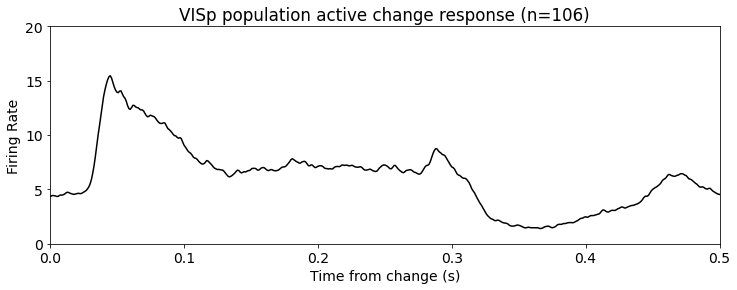

In [945]:
area_of_interest = 'VISp'
#Plot the results
fig, ax = plt.subplots()
fig.set_size_inches([12,4])
ax.plot(bins[:-1]-time_before_change, np.mean(area_change_responses, axis=0), 'k')
ax.set_title('{} population active change response (n={})'\
                .format(area_of_interest, area_change_responses.shape[0]))
ax.set_xlabel('Time from change (s)')
ax.set_ylabel('Firing Rate')

ax.set_xlim([0, 0.5])
ax.set_ylim([0, 20])
fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
                         'v1_change_psth_' + str(session.metadata['mouse_id'])+'_'+session.metadata['session_type']+'.pdf'))

In [941]:
all_units[(all_units['mouse_id']==608672)&
         (all_units['structure_acronym'].str.contains('VISp'))&
        ~all_units['structure_acronym'].str.contains('m')].pivot_table(index=['stim', 'structure_acronym'], values='amplitude', aggfunc='count')

amplitude
stim    structure_acronym           
EPHYS_1 VISp1                      5
        VISp2/3                   66
        VISp4                     35
        VISp5                     36
        VISp6a                     7
        VISp6b                     8
EPHYS_2 VISp1                     13
        VISp2/3                   31
        VISp4                     25
        VISp5                     39
        VISp6a                    27
EPHYS_3 VISp1                      2
        VISp2/3                    5
        VISp4                     25
        VISp5                     28
        VISp6a                    37
        VISp6b                    16
        VISpor5                    9
        VISpor6a                  49
        VISpor6b                  10
EPHYS_4 VISp1                      2
        VISp2/3                   61
        VISp4                     36
        VISp5                     50
        VISp6a                    29
        VISpor6a                  18

## Plot responses across days to one of the images (precomputed on cluster)

In [397]:
quality_filter = ((all_units['isi_violations'] < 0.5) & 
                    (all_units['amplitude_cutoff']< 0.1) & 
                    (all_units['presence_ratio'] > 0.95) & 
                    (all_units['quality'] == 'good') &
                    ([True]*len(all_units)))

all_good_units = dg_good[quality_filter]

In [398]:
len(all_good_units)

59176

In [137]:
1175067685 in PASSING_EPHYS_SESSION_IDS

True

In [ ]:
rdir = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\im115_r_responses"
# rfiles = os.listdir(rdir)
# rfiles = [r for r in rfiles if os.path.isfile(os.path.join(rdir, r))]
    
stim_units = all_good_units[all_good_units['session_type']=='EPHYS_3']
v1_stim_units = stim_units[(stim_units['isi_label']=='VISp') &
                            stim_units['is_sig_rf']]#&
                            #(stim_units['azimuth_rf'] > 20)&
                            #(stim_units['azimuth_rf'] < 60)&
                            #(stim_units['elevation_rf'] > -10)&
                            #(stim_units['elevation_rf'] < 30)]
session_responses = []
for session in v1_stim_units['session'].unique():

    fig, ax = plt.subplots()
    fig.suptitle(session)

    v1_session_ids = v1_stim_units[v1_stim_units['session']==session]['unit_id'].values
    responses = []
    for r in rfiles:
        ruid = int(r.split('.')[0])
        if ruid in v1_session_ids:
            uresp = np.load(os.path.join(rdir, r))
            responses.append(uresp-np.mean(uresp[1000:1010]))
    
    print(len(responses))
    ax.plot(np.nanmean(responses, axis=0))
    ax.set_xlim([900, 1500])
    ax.set_title(len(responses))
    session_responses.append(np.mean(responses,axis=0))

In [187]:
len(dg_good)
len(vbn_good)

262177

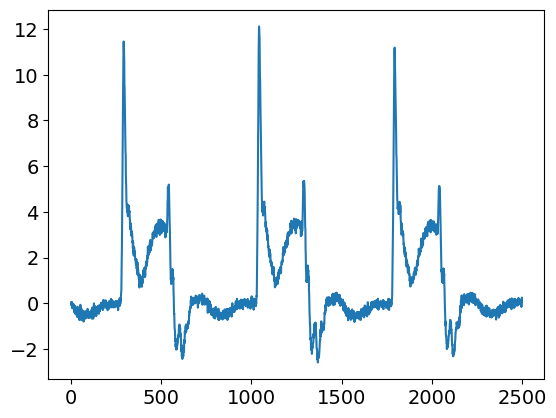

In [131]:
plt.plot(np.mean(session_responses, axis=0))

EPHYS_1
num units: 595, num sessions: 12, num mice: 12
EPHYS_2
num units: 482, num sessions: 11, num mice: 11
EPHYS_3
num units: 536, num sessions: 12, num mice: 12
EPHYS_4
num units: 446, num sessions: 11, num mice: 11


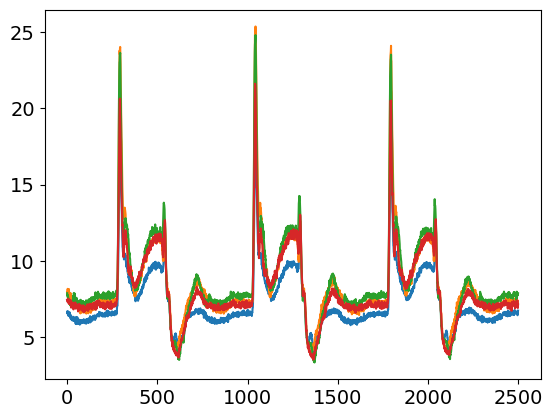

In [401]:
rdir = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\im115_r_responses"
rfiles = os.listdir(rdir)
rfiles = [r for r in rfiles if os.path.isfile(os.path.join(rdir, r))]
day_responses = []
for stim in ['EPHYS_1', 'EPHYS_2', 'EPHYS_3', 'EPHYS_4']:
    print(stim)
    stim_units = all_good_units[all_good_units['session_type']==stim]
    v1_stim_units = stim_units[(stim_units['isi_label']=='VISp') &
                                stim_units['is_sig_rf']]#&
                                #(stim_units['azimuth_rf'] > 20)&
                                #(stim_units['azimuth_rf'] < 60)&
                                #(stim_units['elevation_rf'] > -10)&
                                #(stim_units['elevation_rf'] < 30)]
    
    v1_stim_unit_ids = v1_stim_units['unit_id'].values
    num_sessions = v1_stim_units["session"].unique().size
    num_mice = v1_stim_units['mouse_id'].unique().size
    responses = []
    for r in rfiles:
        ruid = int(r.split('.')[0])
        if ruid in v1_stim_unit_ids:
            uresp = np.load(os.path.join(rdir, r))
            responses.append(uresp)
    
    print(f'num units: {len(responses)}, num sessions: {num_sessions}, num mice: {num_mice}')
    day_responses.append(np.nanmean(responses,axis=0))
    plt.plot(np.nanmean(responses, axis=0))

In [394]:
day_responses = np.array(day_responses)
day_responses.shape

(4, 2500)

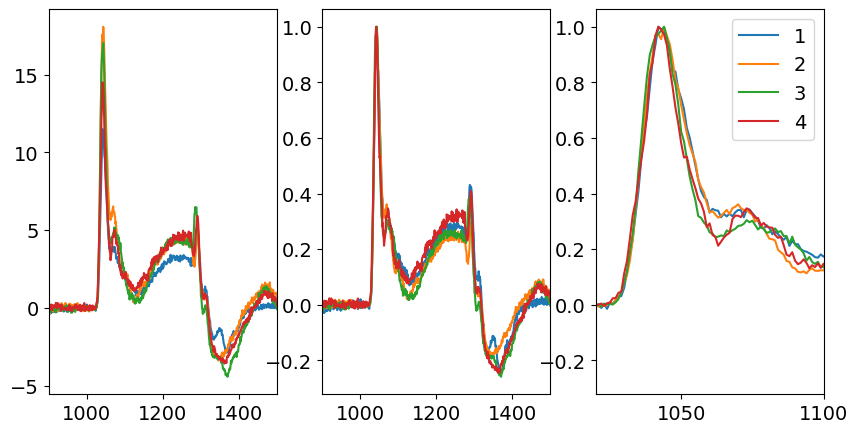

In [402]:
day_responses = np.array(day_responses)
day_baseline_sub = [d-np.mean(d[1000:1010]) for d in day_responses]
day_normed = [d/max(d) for d in day_baseline_sub]
fig, ax = plt.subplots(1, 3)
fig.set_size_inches([10, 5])
ax[0].plot(np.array(day_baseline_sub).T)
ax[0].set_xlim([900, 1500])
ax[1].plot(np.array(day_normed).T)
ax[1].set_xlim([900, 1500])

ax[2].plot(np.array(day_normed).T)
ax[2].set_xlim([1020, 1100])

ax[2].legend(['1', '2', '3', '4'])
# fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
#                          'v1_im115_psth_normed_across_stimdays.pdf'))

In [129]:
stim_units = all_good_units
v1_stim_units = stim_units[(stim_units['structure_acronym'].str.contains('VISp'))&
                    ~stim_units['structure_acronym'].str.contains('m')&
                    ~stim_units['structure_acronym'].str.contains('por')&
                    stim_units['is_sig_rf']]

In [130]:
v1_stim_units.pivot_table(index='stim', values=['azimuth_rf', 'elevation_rf'], aggfunc='mean')

KeyError: 'stim'